# The final results used in the report 

In [1]:
import os
import sys
import re
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sklearn
from sklearn.decomposition import PCA
import umap
from scipy.spatial.distance import cosine
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import pairwise_distances, euclidean_distances
from sklearn.metrics import mean_squared_error, r2_score
import warnings
warnings.filterwarnings("ignore")

class comparison:
    """
    A class used to compare two datasets based on their embeddings and ground truth grades

    ...

    Attributes
    ----------
    path_1_emb : str
        Path to the embedding files of the first dataset
    path_1_text : str
        Path to the LaTeX source files of the first dataset
    path_2_emb : str or None
        Path to the embedding files of the second dataset (optional)
    path_2_text : str or None
        Path to the LaTeX source files of the second dataset (optional)
    REMOVE_BAD : bool
        Flag to remove bad samples (graded but empty text)
    REMOVE_EMPTY : bool
        Flag to remove samples with empty LaTeX content
    COMPARE : bool
        Whether comparison between two datasets is enabled
    FULL1 : bool
        Whether the first dataset consists of subproblems (True) or whole problems (False)
    FULL2 : bool
        Whether the second dataset consists of subproblems (True) or whole problems (False)
    data_1 : dict
        Dictionary to store processed dataframes from the first dataset
    data_2 : dict
        Dictionary to store processed dataframes from the second dataset
    name_1 : str
        Readable name of the first dataset
    name_2 : str
        Readable name of the second dataset

    Methods
    -------
    load_data()
        Loads and preprocesses the data from the given paths

    prepare_data(REMOVE_BAD=False, REMOVE_EMPTY=False)
        Filters the data according to empty or bad entries based on the provided flags

    clustering(...)
        Applies clustering on the dataset(s) using selected clustering and dimension reduction techniques

    plotting(dimension_reduction_method="PCA")
        Visualizes the embeddings using PCA or UMAP, colored by grade

    get_data()
        Returns the processed data as dictionaries of dataframes

    analyze(features_to_analyze, comparing_values=None, detail=False, plot=True)
        Performs quantitative evaluation (MSE, R2, custom metrics) and visual comparison between datasets
    """

    def __init__(self, path_1_emb , path_1_text, path_2_emb=None, path_2_text=None):
        """
        Initializes the comparison class with paths to one or two datasets.

        Parameters
        ----------
        path_1_emb : str
            Path to the embedding files of the first dataset
        path_1_text : str
            Path to the LaTeX text files of the first dataset
        path_2_emb : str or None
            Path to the embedding files of the second dataset (optional)
        path_2_text : str or None
            Path to the LaTeX text files of the second dataset (optional)
        """
        WD = os.getcwd()
        self.path_1_emb = WD+path_1_emb
        self.path_2_emb = WD+path_2_emb  # path_2 is optional, defaults to None
        self.path_1_text = WD+path_1_text
        self.path_2_text = WD+path_2_text  # path_2 is optional, defaults to None
        print(f"Working Directory: {WD}")
        self.REMOVE_BAD = False  # Flag to remove empty files
        self.REMOVE_EMPTY = False
        self.COMPARE = True  # Flag to compare two datasets
        self.FULL1 = False  # False if we look at full questions and True if we look at subquestions
        self.FULL2 = False  # False if we look at full questions and True if we look at subquestions
        self.data_1 = {} # Dictionary of all data of path 1
        self.data_2 = {} # Dictionary of all data of path 2
        self.name_1 = path_1_emb.split("/")[-1] # name of the first path
        self.name_2 = path_2_emb.split("/")[-1] # name of the second path
        self.name_1 = self.name_1.replace("_", " ") # replace spaces with underscores
        self.name_2 = self.name_2.replace("_", " ") # replace spaces with underscores
        # Check if both paths exists
        # if not os.path.exists(path_1_emb):
        #     raise FileNotFoundError(f"The path {path_1_emb} does not exist.")
        # if path_2_emb is not None and not os.path.exists(path_2_emb):
        #     raise FileNotFoundError(f"The path {path_2_emb} does not exist.")

        # Check if path_2_emb is provided, and handle accordingly
        if path_2_emb is None:
            self.COMPARE = False
            print("Only path_1 is provided, proceeding with single dataset analysis.")
        else:
            print(f"Comparing two datasets: {self.name_1} and {self.name_2}")

    def load_data(self):
        """
        Loads embeddings, LaTeX files, and grades from the specified paths,
        validates their formats, and organizes them into dataframes.

        Raises
        ------
        ValueError
            If the file formats are inconsistent or mixed (problems and subproblems)
        """
        def get_student_id(filename):
            return int(filename.split('_')[0].lstrip('0'))

        def is_empty_latex_file(path):
            try:
                if os.path.getsize(path) == 0:
                    return True
                content = Path(path).read_text(encoding='utf-8').strip()
                return content == "No content found."
            except Exception as e:
                print(f"Error reading {path}: {e}")
                return False

        def load_ground_truth(path):
            df = pd.read_csv(path, header=None)
            df.columns = ["Student ID", "Grade"]
            df["Student ID"] = df["Student ID"].astype(int)
            return df.set_index("Student ID")

        def get_embedding(directory, file):
            with open(os.path.join(directory, file), "r") as f:
                data = json.load(f)
                embedding = data["data"][0]["embedding"]
                if isinstance(embedding[0], list):
                    embedding = np.squeeze(embedding)
                elif isinstance(embedding, list):
                    embedding = np.array(embedding)
            return embedding

        def build_dataframe(files, latex_files, label_prefix, path, path_text, path_grades, Full):
            data = pd.DataFrame(columns=["Student ID", "Embedding", "Empty"])
            for file in files:
                student_id = get_student_id(file)
                embedding = get_embedding(path, file)
                data.loc[len(data.index)] = [student_id, np.array(embedding), "has text"]

            data["Student ID"] = data["Student ID"].astype(int)
            data.set_index("Student ID", inplace=True)

            for tex_file in latex_files:
                tex_path = os.path.join(path_text, tex_file)
                if is_empty_latex_file(tex_path):
                    student_id = get_student_id(tex_file)
                    if student_id in data.index:
                        data.loc[student_id, "Empty"] = "is empty"
            if Full:
                texts = []
                for tex_file in latex_files:
                    tex_path = os.path.join(path_text, tex_file)
                    try:
                        content = Path(tex_path).read_text(encoding='utf-8')
                        texts.append(content)
                        if content.strip() == "No content found." or os.path.getsize(tex_path) == 0:
                            student_id = get_student_id(tex_file)
                            if student_id in data.index:
                                data.loc[student_id, "Empty"] = "is empty"
                    except Exception as e:
                        print(f"Error reading {tex_path}: {e}")
                        texts.append("")

                #data["Text"] = texts
            problem_no = f"problem_{label_prefix}"
            groundtruth_path = os.path.join(path_grades, f"{problem_no}.csv")
            ground_truth = load_ground_truth(groundtruth_path)

            df = pd.merge(data, ground_truth, on="Student ID", how="inner")
            return problem_no, df
        
        def check_files(filenames, extension):
            pattern = rf'^\d+_(\d[a-zA-Z]?)\.{extension}$'
            incorrect_files = [file for file in filenames if not re.match(pattern, file)]
            if incorrect_files:
                raise ValueError(f"Incorrect files found: {', '.join(incorrect_files)}")

        def check_all_problem_or_subproblem(file_list, extension):
            subproblem_pattern = rf'^\d+_(\d[a-e]|[1-4][a-d])\.{extension}$'
            problem_pattern = rf'^\d+_(\d)\.{extension}$'
            is_subproblem = all(re.match(subproblem_pattern, file) for file in file_list)
            is_problem = all(re.match(problem_pattern, file) for file in file_list)
            if is_subproblem:
                return True
            elif is_problem:
                return False
            else:
                raise ValueError("The file list contains a mix of problems and subproblems.")

        Case = 0

        for path in [self.path_1_emb, self.path_2_emb]:
            if path is None:
                continue

            if path == self.path_1_emb:
                Case = 1
            elif path == self.path_2_emb:
                Case = 2

            files = sorted([f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))],
                        key=lambda x: int(x.split("_")[0]))
            check_files(files, "json")

            full_check = check_all_problem_or_subproblem(files, "json")
            if Case == 1:
                self.FULL1 = full_check
                path_text = self.path_1_text
            elif Case == 2:
                self.FULL2 = full_check
                path_text = self.path_2_text

            parent_directory = os.path.dirname(path)
            
            path_grades = os.path.join(parent_directory, "grades")

            text = sorted([f for f in os.listdir(path_text) if os.path.isfile(os.path.join(path_text, f))],
                        key=lambda x: int(x.split("_")[0]))
            check_files(text, "tex")

            text_check = check_all_problem_or_subproblem(text, "tex")
            if Case == 1 and self.FULL1 != text_check:
                raise ValueError("The embeddings and latex files are a mix of problems and subproblems.")
            elif Case == 2 and self.FULL2 != text_check:
                raise ValueError("The embeddings and latex files are a mix of problems and subproblems.")

            Full = self.FULL1 if Case == 1 else self.FULL2

            label_sets = {
                True: {
                    1: 'abcde',
                    2: 'abcd',
                    3: 'abcd',
                    4: 'abcde'
                },
                False: {
                    1: '',
                    2: '',
                    3: '',
                    4: ''
                }
            }

            labels = label_sets[Full]
            for number, suffix in labels.items():
                for letter in suffix or ['']:
                    label = f"{number}{letter}" if letter else f"{number}"
                    json_files = [f for f in files if f.endswith('.json') and f.split('_')[1].startswith(label)]
                    tex_files = [f for f in text if f.endswith('.tex') and f.split('_')[1].startswith(label)]

                    problem_no, df = build_dataframe(
                        json_files, tex_files, label,
                        path, path_text, path_grades, Full
                    )

                    if Case == 1:
                        self.data_1[problem_no] = df
                    elif Case == 2:
                        self.data_2[problem_no] = df

        print("Data loaded successfully.")

    def prepare_data(self, REMOVE_BAD=False, REMOVE_EMPTY=False):
        """
        Prepares the loaded datasets by filtering out empty or bad samples. 
        It synchronizes the indices of the two datasets based on common task IDs.

        Parameters
        ----------
        REMOVE_BAD : bool
            Removes entries with positive grades but empty LaTeX content
        REMOVE_EMPTY : bool
            Removes entries with any empty LaTeX content

        Raises
        ------
        ValueError
            If data is not loaded or input parameters are not booleans
        """
        # Check if the data has been loaded
        if not self.data_1 and not self.data_2:
            raise ValueError("Data has not been loaded. Please call load_data() first.")
        
        # Check if the REMOVE_BAD and REMOVE_EMPTY flag is set
        if not isinstance(REMOVE_BAD, bool):
            raise ValueError("REMOVE_BAD should be a boolean value.")
        if not isinstance(REMOVE_EMPTY,bool):
            raise ValueError("REMOVE_EMPTY should be a boolean value.")
        

        from collections import defaultdict

        def extract_task_id(key):
            # Extract numeric task ID from keys like 'problem_1a' → '1'
            return ''.join(filter(str.isdigit, key))

        def filter_df(df, remove_bad, remove_empty):
            mask = pd.Series(True, index=df.index)
            if remove_bad:
                mask &= ~((df["Grade"] > 0) & (df["Empty"] == "is empty"))
            if remove_empty:
                mask &= ~(df["Empty"] == "is empty")
            return df[mask]

        # Set filter flags
        self.REMOVE_BAD = REMOVE_BAD
        self.REMOVE_EMPTY = REMOVE_EMPTY

        # Step 1: Apply filtering to all dataframes
        for key in self.data_1:
            self.data_1[key] = filter_df(self.data_1[key], self.REMOVE_BAD, self.REMOVE_EMPTY)

        for key in self.data_2:
            self.data_2[key] = filter_df(self.data_2[key], self.REMOVE_BAD, self.REMOVE_EMPTY)

        # Step 2: Group keys by task number
        task_keys_1 = defaultdict(list)
        task_keys_2 = defaultdict(list)

        for key in self.data_1:
            task_id = extract_task_id(key)
            task_keys_1[task_id].append(key)

        for key in self.data_2:
            task_id = extract_task_id(key)
            task_keys_2[task_id].append(key)

        # Step 3: Synchronize rows based on shared task logic
        for task_id in set(task_keys_1) & set(task_keys_2):
            keys_1 = task_keys_1[task_id]
            keys_2 = task_keys_2[task_id]

            # --- Case 1: data_1 has group key, data_2 has subtasks ---
            if len(keys_1) == 1 and len(keys_2) > 1:
                combined_key = keys_1[0]
                subtask_keys = keys_2
                shared_idx = set.intersection(*(set(self.data_2[k].index) for k in subtask_keys))
                self.data_1[combined_key] = self.data_1[combined_key].loc[list(shared_idx)]
                for k in subtask_keys:
                    self.data_2[k] = self.data_2[k].loc[list(shared_idx)]

            # --- Case 2: both sides have subtasks ---
            elif len(keys_1) > 1 and len(keys_2) > 1:
                common_subtasks = set(keys_1) & set(keys_2)
                for key in common_subtasks:
                    idx = set(self.data_1[key].index) & set(self.data_2[key].index)
                    self.data_1[key] = self.data_1[key].loc[list(idx)]
                    self.data_2[key] = self.data_2[key].loc[list(idx)]

            # --- Case 3: data_1 has subtasks, data_2 has group key ---
            elif len(keys_2) == 1 and len(keys_1) > 1:
                combined_key = keys_2[0]
                subtask_keys = keys_1
                shared_idx = set.intersection(*(set(self.data_1[k].index) for k in subtask_keys))
                self.data_2[combined_key] = self.data_2[combined_key].loc[list(shared_idx)]
                for k in subtask_keys:
                    self.data_1[k] = self.data_1[k].loc[list(shared_idx)]
        print("Data preparation completed.")

    def clustering(self, 
                   metric='euclidean', 
                   linkage_type='ward', 
                   distance_threshold=None, 
                   number_of_clusters=None,
                   dimensions=2, 
                   type_of_clustering='Agglomerative', 
                   type_of_dimension_reduction=None,
                   type_of_scaler='StandardScaler',
                   return_labels=False):
        """
        Applies clustering to the datasets with optional dimensionality reduction.

        Parameters
        ----------
        metric : str
            Distance metric to use for clustering
        linkage_type : str
            Type of linkage for agglomerative clustering
        distance_threshold : float or None
            Threshold to determine the number of clusters
        number_of_clusters : int or None
            The number of clusters to form
        dimensions : int
            Target dimensionality for reduction
        type_of_clustering : str
            Clustering algorithm to use ('Agglomerative', 'KMeans', 'KMedoids')
        type_of_dimension_reduction : str or None
            Method for dimensionality reduction ('PCA' or 'UMAP')
        type_of_scaler : str
            Scaler to normalize the data ('StandardScaler' or 'MinMaxScaler')
        return_labels : bool
            Whether to return the cluster labels

        Returns
        -------
        list of np.ndarray
            Cluster labels for both datasets if return_labels is True

        Raises
        ------
        ValueError
            If invalid parameter combinations are provided
        """
        np.random.seed(0)  # Set random seed for reproducibility

        # Check if the data has been loaded
        if not self.data_1 and not self.data_2:
            raise ValueError("Data has not been loaded. Please call load_data() first.")
        

        labels_1 = []
        labels_2 = []
        for key in self.data_1.keys():
            df = self.data_1[key]
            data = np.array(df["Embedding"].tolist())

            # Data Scaling
            if type_of_scaler == 'StandardScaler':
                scaler = StandardScaler()
            elif type_of_scaler == 'MinMaxScaler':
                scaler = MinMaxScaler()
            else:
                raise ValueError(f"Scaler {type_of_scaler} is not supported")
               
            data = scaler.fit_transform(data)

            # Dimensionality Reduction
            if type_of_dimension_reduction == 'PCA':
                pca = PCA(n_components=dimensions)
                data = pca.fit_transform(data)
            elif type_of_dimension_reduction == 'UMAP':
                umap_model = umap.UMAP(n_components=dimensions)
                data = umap_model.fit_transform(data)
            elif type_of_dimension_reduction is None:
                pass
            else:
                raise ValueError(f"Dimension reduction type {type_of_dimension_reduction} is not supported")
            
            # Clustering
            if type_of_clustering == 'Agglomerative':
                # Check that exactly one of `n_clusters` or `distance_threshold` is provided
                if number_of_clusters is not None and distance_threshold is not None:
                    raise ValueError("You cannot provide both `n_clusters` and `distance_threshold`. Please provide only one.")
                
                if number_of_clusters is not None:
                    # Use `n_clusters` if provided        
                    clustering = AgglomerativeClustering(n_clusters=number_of_clusters, metric=metric, linkage=linkage_type)
                elif distance_threshold is not None:
                    # Use `distance_threshold` if provided
                    clustering = AgglomerativeClustering(distance_threshold=distance_threshold,n_clusters=number_of_clusters, metric=metric, linkage=linkage_type, compute_full_tree=True)
                else:
                    # Raise error if neither `n_clusters` nor `distance_threshold` is provided
                    raise ValueError("Either `n_clusters` or `distance_threshold` must be provided for Agglomerative clustering.")
            
                clustering_labels = clustering.fit_predict(data)
            
            elif type_of_clustering == 'KMeans':
                if number_of_clusters is None:
                    raise ValueError("For KMeans, number_of_clusters must be provided.")
                clustering = KMeans(n_clusters=number_of_clusters, random_state=0)
                clustering_labels = clustering.fit_predict(data)
            
            elif type_of_clustering == 'KMedoids':
                if number_of_clusters is None:
                    raise ValueError("For KMedoids, number_of_clusters must be provided.")
                clustering = KMedoids(n_clusters=number_of_clusters, metric=metric)
                clustering_labels = clustering.fit_predict(data)
            else:
                raise ValueError(f"Clustering type {type_of_clustering} is not supported")
            
            # Add clustering labels to the dataframe
            df["Clustering"] = clustering_labels
            self.data_1[key] = df

            if return_labels:
                labels_1.append(clustering_labels)
        
        for key in self.data_2.keys():
            df_2 = self.data_2[key]
            data_2 = np.array(df_2["Embedding"].tolist())
            # Data Scaling
            if type_of_scaler == 'StandardScaler':
                scaler = StandardScaler()
            elif type_of_scaler == 'MinMaxScaler':
                scaler = MinMaxScaler()
            else:
                raise ValueError(f"Scaler {type_of_scaler} is not supported")
            
            data_2 = scaler.fit_transform(data_2)

            # Dimensionality Reduction
            if type_of_dimension_reduction == 'PCA':
                pca = PCA(n_components=dimensions)
                data_2 = pca.fit_transform(data_2)
            elif type_of_dimension_reduction == 'UMAP':
                umap_model = umap.UMAP(n_components=dimensions)
                data_2 = umap_model.fit_transform(data_2)
            elif type_of_dimension_reduction is None:
                pass
            else:
                raise ValueError(f"Dimension reduction type {type_of_dimension_reduction} is not supported")
            
            # Clustering
            if type_of_clustering == 'Agglomerative':
                if number_of_clusters is not None:
                    clustering = AgglomerativeClustering(n_clusters=number_of_clusters, metric=metric, linkage=linkage_type)
                elif distance_threshold is not None:
                    clustering = AgglomerativeClustering(distance_threshold=distance_threshold,n_clusters=number_of_clusters, metric=metric, linkage=linkage_type)
                else:
                    raise ValueError("Either number_of_clusters or distance_threshold must be provided for Agglomerative clustering.")
                clustering_labels_2 = clustering.fit_predict(data_2)
            
            elif type_of_clustering == 'KMeans':
                if number_of_clusters is None:
                    raise ValueError("For KMeans, number_of_clusters must be provided.")
                clustering = KMeans(n_clusters=number_of_clusters, random_state=0)
                clustering_labels_2 = clustering.fit_predict(data_2)
            
            elif type_of_clustering == 'KMedoids':
                if number_of_clusters is None:
                    raise ValueError("For KMedoids, number_of_clusters must be provided.")
                clustering = KMedoids(n_clusters=number_of_clusters, metric=metric)
                clustering_labels_2 = clustering.fit_predict(data_2)
            else:
                raise ValueError(f"Clustering type {type_of_clustering} is not supported")
            
            # Add clustering labels to the dataframe
            df_2["Clustering"] = clustering_labels_2
            self.data_2[key] = df_2

            if return_labels:
                labels_2.append(clustering_labels_2)
        
        print("Clustering completed.")
        
        if return_labels:
            return labels_1, labels_2
    

    def plotting(self, dimension_reduction_method="PCA"):
        """
        Visualizes the embeddings for both datasets using PCA or UMAP.

        Parameters
        ----------
        dimension_reduction_method : str
            The method used for dimensionality reduction ('PCA' or 'UMAP')

        Raises
        ------
        ValueError
            If an unsupported dimensionality reduction method is specified
        """
         # Standardize data before dimensionality reduction

        if self.FULL1 == self.FULL2 and self.FULL1 == True:

            label_ranges = {
                            1: 'abcde',
                            2: 'abcd',
                            3: 'abcd',
                            4: 'abcde'
                        }
            for number in label_ranges:
                for letter in label_ranges[number]:
                    # Get the data for the specific problem and letter
    
                    df_1 = self.data_1[f"problem_{number}{letter}"]
                    df_2 = self.data_2[f"problem_{number}{letter}"]
                    
                    # Extract embeddings and grades
                    X_1 = np.array(df_1["Embedding"].tolist())
                    X_2 = np.array(df_2["Embedding"].tolist())
                    grades_1 = np.array(df_1["Grade"].tolist())
                    grades_2 = np.array(df_2["Grade"].tolist())
                    scaler = StandardScaler()
                    X_scaled_1 = scaler.fit_transform(X_1)
                    X_scaled_2 = scaler.fit_transform(X_2)

                    # Apply dimensionality reduction method (PCA or UMAP)
                    if dimension_reduction_method == "PCA":
                        # Apply PCA for 2D visualization
                        pca = PCA(n_components=2)
                        X_reduced_1 = pca.fit_transform(X_scaled_1)
                        X_reduced_2 = pca.fit_transform(X_scaled_2)
                        
                        # Convert to DataFrame for plotting
                        df_reduced_1 = pd.DataFrame(X_reduced_1, columns=['PC1', 'PC2'])
                        df_reduced_2 = pd.DataFrame(X_reduced_2, columns=['PC1', 'PC2'])
                        df_reduced_1['Grade'] = grades_1
                        df_reduced_2['Grade'] = grades_2
                        
                        # Plot PCA for both embeddings
                        plt.figure(figsize=(12, 6))
                    
                        # Plot PCA colored with grade
                        plt.subplot(1, 2, 1)
                        sns.scatterplot(x='PC1', y='PC2', hue=df_reduced_1['Grade'], palette='plasma', data=df_reduced_1, alpha=0.8)
                        plt.title(f"PCA for {self.name_1}: Ground truth Visualization")
                        plt.xlabel("Principal Component 1")
                        plt.ylabel("Principal Component 2")
                        plt.legend(title="Grade", bbox_to_anchor=(1, 1))

                        # Plot PCA for the second dataset
                        plt.subplot(1, 2, 2)
                        sns.scatterplot(x='PC1', y='PC2', hue=df_reduced_2['Grade'], palette='plasma', data=df_reduced_2, alpha=0.8)
                        plt.title(f"PCA for {self.name_2}: Ground truth Visualization")
                        plt.xlabel("Principal Component 1")
                        plt.ylabel("Principal Component 2")
                        plt.legend(title="Grade", bbox_to_anchor=(1, 1))
                        
                    elif dimension_reduction_method == "UMAP":
                        # Apply UMAP for 2D visualization
                        umap_model = umap.UMAP(n_components=2, random_state=0)
                        X_reduced_1 = umap_model.fit_transform(X_scaled_1)
                        X_reduced_2 = umap_model.fit_transform(X_scaled_2)
                        
                        # Convert to DataFrame for plotting
                        df_reduced_1 = pd.DataFrame(X_reduced_1, columns=['UMAP1', 'UMAP2'])
                        df_reduced_2 = pd.DataFrame(X_reduced_2, columns=['UMAP1', 'UMAP2'])
                        df_reduced_1['Grade'] = grades_1
                        df_reduced_2['Grade'] = grades_2
                        
                        # Plot UMAP for both embeddings
                        plt.figure(figsize=(12, 6))
                        
                        # Plot UMAP colored with grade
                        plt.subplot(1, 2, 1)
                        sns.scatterplot(x='UMAP1', y='UMAP2', hue=df_reduced_1['Grade'], palette='plasma', data=df_reduced_1, alpha=0.8)
                        plt.title(f"UMAP for {self.name_1}: Ground truth Visualization")
                        plt.xlabel("UMAP Dimension 1")
                        plt.ylabel("UMAP Dimension 2")
                        plt.legend(title="Grade", bbox_to_anchor=(1, 1))

                        # Plot UMAP for the second dataset
                        plt.subplot(1, 2, 2)
                        sns.scatterplot(x='UMAP1', y='UMAP2', hue=df_reduced_2['Grade'], palette='plasma', data=df_reduced_2, alpha=0.8)
                        plt.title(f"UMAP for {self.name_2}: Ground truth Visualization")
                        plt.xlabel("UMAP Dimension 1")
                        plt.ylabel("UMAP Dimension 2")
                        plt.legend(title="Grade", bbox_to_anchor=(1, 1))

                    else:
                        raise ValueError(f"Invalid dimension reduction method: {dimension_reduction_method}. Choose 'PCA' or 'UMAP'.")
                    
                    plt.suptitle(f"Problem {number}{letter}: Embedding Visualization", fontsize=16, y=1.05)
                    plt.tight_layout()
                    plt.show()

        elif self.FULL1 == self.FULL2 and self.FULL1 == False:
            label_ranges = {1,2,3,4}
            for number in label_ranges:
                    # Get the data for the specific problem and letter
                    df_1 = self.data_1[f"problem_{number}"]
                    df_2 = self.data_2[f"problem_{number}"]

                    # Extract embeddings and grades
                    X_1 = np.array(df_1["Embedding"].tolist())
                    X_2 = np.array(df_2["Embedding"].tolist())
                    grades = np.array(df_1["Grade"].tolist())
                    scaler = StandardScaler()
                    X_scaled_1 = scaler.fit_transform(X_1)
                    X_scaled_2 = scaler.fit_transform(X_2)

                    # Apply dimensionality reduction method (PCA or UMAP)
                    if dimension_reduction_method == "PCA":
                        # Apply PCA for 2D visualization
                        pca = PCA(n_components=2)
                        X_reduced_1 = pca.fit_transform(X_scaled_1)
                        X_reduced_2 = pca.fit_transform(X_scaled_2)
                        
                        # Convert to DataFrame for plotting
                        df_reduced_1 = pd.DataFrame(X_reduced_1, columns=['PC1', 'PC2'])
                        df_reduced_2 = pd.DataFrame(X_reduced_2, columns=['PC1', 'PC2'])
                        df_reduced_1['Grade'] = grades
                        df_reduced_2['Grade'] = grades
                        
                        # Plot PCA for both embeddings
                        plt.figure(figsize=(12, 6))
                    
                        # Plot PCA colored with grade
                        plt.subplot(1, 2, 1)
                        sns.scatterplot(x='PC1', y='PC2', hue=df_reduced_1['Grade'], palette='plasma', data=df_reduced_1, alpha=0.8)
                        plt.title(f"PCA for {self.name_1}: Ground truth Visualization")
                        plt.xlabel("Principal Component 1")
                        plt.ylabel("Principal Component 2")
                        plt.legend(title="Grade", bbox_to_anchor=(1, 1))

                        # Plot PCA for the second dataset
                        plt.subplot(1, 2, 2)
                        sns.scatterplot(x='PC1', y='PC2', hue=df_reduced_2['Grade'], palette='plasma', data=df_reduced_2, alpha=0.8)
                        plt.title(f"PCA for {self.name_2}: Ground truth Visualization")
                        plt.xlabel("Principal Component 1")
                        plt.ylabel("Principal Component 2")
                        plt.legend(title="Grade", bbox_to_anchor=(1, 1))
                        
                    elif dimension_reduction_method == "UMAP":
                        # Apply UMAP for 2D visualization
                        umap_model = umap.UMAP(n_components=2, random_state=0)
                        X_reduced_1 = umap_model.fit_transform(X_scaled_1)
                        X_reduced_2 = umap_model.fit_transform(X_scaled_2)
                        
                        # Convert to DataFrame for plotting
                        df_reduced_1 = pd.DataFrame(X_reduced_1, columns=['UMAP1', 'UMAP2'])
                        df_reduced_2 = pd.DataFrame(X_reduced_2, columns=['UMAP1', 'UMAP2'])
                        df_reduced_1['Grade'] = grades
                        df_reduced_2['Grade'] = grades
                        
                        # Plot UMAP for both embeddings
                        plt.figure(figsize=(12, 6))
                        
                        # Plot UMAP colored with grade
                        plt.subplot(1, 2, 1)
                        sns.scatterplot(x='UMAP1', y='UMAP2', hue=df_reduced_1['Grade'], palette='plasma', data=df_reduced_1, alpha=0.8)
                        plt.title(f"UMAP for {self.name_1}: Ground truth Visualization")
                        plt.xlabel("UMAP Dimension 1")
                        plt.ylabel("UMAP Dimension 2")
                        plt.legend(title="Grade", bbox_to_anchor=(1, 1))

                        # Plot UMAP for the second dataset
                        plt.subplot(1, 2, 2)
                        sns.scatterplot(x='UMAP1', y='UMAP2', hue=df_reduced_2['Grade'], palette='plasma', data=df_reduced_2, alpha=0.8)
                        plt.title(f"UMAP for {self.name_2}: Ground truth Visualization")
                        plt.xlabel("UMAP Dimension 1")
                        plt.ylabel("UMAP Dimension 2")
                        plt.legend(title="Grade", bbox_to_anchor=(1, 1))

                    else:
                        raise ValueError(f"Invalid dimension reduction method: {dimension_reduction_method}. Choose 'PCA' or 'UMAP'.")
                    
                    plt.suptitle(f"Problem {number}: Embedding Visualization", fontsize=16, y=1.05)
                    plt.tight_layout()
                    plt.show()
        else:
            print("The datasets are not of the same type (Full and Sub). Please check the data.")
            return None

    def get_data(self):
        """
        Retrieves the internal dataframes for further external analysis.

        Returns
        -------
        dict or tuple of dicts
            If comparing two datasets, returns both datasets as a tuple (data_1, data_2),
            otherwise returns only data_1
        """
        if self.COMPARE:
            return self.data_1, self.data_2
        else:
            return self.data_1

    def analyze(self, features_to_analyze, comparing_values=None, detail=False, plot=True):
        """
        Computes evaluation metrics and optionally visualizes the results for both datasets.

        Parameters
        ----------
        features_to_analyze : list of str
            Metrics to compute ('mse', 'r2', 'own', 'boxplot')
        comparing_values : str or None
            Method of summarizing subproblem results ('avg', 'max', 'min')
        detail : bool
            If True, prints tabulated metric values
        plot : bool
            If True, generates visual plots for the metrics

        Raises
        ------
        ValueError
            If comparing_values is invalid or required preprocessing is not performed
        """
        def plot_results(data_1, data_2, problems, name_1, name_2, feature):
            """
            Helper function to plot the results.
            
            Parameters:
            -----------
            data_1 : list
                Data for the first dataset.
            data_2 : list
                Data for the second dataset.
            problems : list
                List of problem names.
            feature_name : str
                Name of the feature being analyzed.
            """
            plt.figure(figsize=(7, 4))
            if feature == "mse":
                mse_1 = data_1
                mse_2 = data_2
                for i in range(len(problems)):
                # Determine which model has the lower mse value
                    if mse_1[i] < mse_2[i]:
                        # Plot Model 1 as the smaller mse, colored dot
                        plt.scatter(problems[i], mse_1[i], color='b', s=150, zorder=5)
                        plt.scatter(problems[i], mse_2[i], color='grey', s=50, zorder=3)  # Grey for Model 2
                    else:
                        # Plot Model 2 as the larger, colored dot
                        plt.scatter(problems[i], mse_2[i], color='r', s=150, zorder=5)
                        plt.scatter(problems[i], mse_1[i], color='grey', s=50, zorder=3)  # Grey for Model 1

            elif feature == "r2":
                r2_1 = data_1
                r2_2 = data_2
                x_positions = list(range(len(problems)))
                for i in range(len(problems)):
                    # Determine which model has the lower mse value
                    # if r2_1[i] > r2_2[i]:
                    #     # Plot Model 1 as the smaller mse, colored dot
                    #     plt.scatter(problems[i], r2_1[i], color='b', s=150)
                    #     plt.scatter(problems[i], r2_2[i], color='grey', s=50)
                    # else:
                    #     # Plot Model 2 as the larger, colored dot
                    #     plt.scatter(problems[i], r2_2[i], color='r', s=150)
                    #     plt.scatter(problems[i], r2_1[i], color='grey', s=50)
                    key = "problem_" + problems[i]
                    count_1 = len(self.data_1.get(key, []))  # Default to 0 if key missing
                    count_2 = len(self.data_2.get(key, []))  # Default to 0 if key missing
                    x = x_positions[i]  # numeric x-coordinate

                    if r2_1[i] > r2_2[i]:
                        # Model 1 wins
                        plt.scatter(problems[i], r2_1[i], color='b', s=150)
                        plt.scatter(problems[i], r2_2[i], color='grey', s=50)
                        # plt.text(x+0.5, r2_1[i] , str(count_1), ha='center', fontsize=9)
                        # plt.text(x+0.5, r2_2[i] , str(count_2), ha='center', fontsize=9)
                    else:
                        # Model 2 wins
                        plt.scatter(problems[i], r2_2[i], color='r', s=150)
                        plt.scatter(problems[i], r2_1[i], color='grey', s=50)
                        # plt.text(x+0.5, r2_1[i] , str(count_1), ha='center', fontsize=9)
                        # plt.text(x+0.5, r2_2[i] , str(count_2), ha='center', fontsize=9)
            
            elif feature == "own":
                own_1 = data_1
                own_2 = data_2
                for i in range(len(problems)):
                    # Determine which model has the lower absolute error value
                    if own_1[i] < own_2[i]:
                        # Plot Model 1 as the smaller mse, colored dot
                        plt.scatter(problems[i], own_1[i], color='b', s=150)
                        plt.scatter(problems[i], own_2[i], color='grey', s=50)
                    else:
                        # Plot Model 2 as the larger, colored dot
                        plt.scatter(problems[i], own_2[i], color='r', s=150)
                        plt.scatter(problems[i], own_1[i], color='grey', s=50)

            # We plot one initial point for each model to create the legend
            plt.scatter([], [], color='b', label=f"{name_1}", s=150)  # Empty plot for legend
            plt.scatter([], [], color='r', label=f"{name_2}", s=150)  # Empty plot for legend

        
            # Adding titles and labels
            plt.title(f'{feature} Values for Two Models')
            plt.xlabel('Problem')
            plt.ylabel(f'{feature}')
            plt.grid(True)

            # Show the legend once after the loop
            plt.legend()

            # Show the plot
            plt.tight_layout()
            plt.show()

        # TODO : Add own metric or poxplot to the cases where not the same size
        if "boxplot" in features_to_analyze or "own" in features_to_analyze:
            if self.FULL1 != self.FULL2:
                print("Boxplot and own metric analysis is only available for datasets which are the same size.")
                print()
                print("This needs to be fixed in the future.")
                return None
            
        print("Analyzing data...")

        if self.FULL1 == self.FULL2:
            print("Both datasets are of the same type.")
            if "mse" in features_to_analyze:
                mse_1 = []
                mse_2 = []
                problems = []
                for key in self.data_1.keys():
                    df = self.data_1[key]
                    df = df[['Grade','Clustering', 'Embedding']]

                    cluster_groups = df.groupby('Clustering')
                    cluster_mean = cluster_groups['Grade'].mean()

                    df['Cluster Mean'] = df['Clustering'].map(cluster_mean)

                    mse = mean_squared_error(df['Grade'], df['Cluster Mean'])
                    mse_1.append(mse)
                    problems.append(key)

                for key in self.data_2.keys():
                    df = self.data_2[key]
                    df = df[['Grade','Clustering', 'Embedding']]

                    cluster_groups = df.groupby('Clustering')
                    cluster_mean = cluster_groups['Grade'].mean()

                    df['Cluster Mean'] = df['Clustering'].map(cluster_mean)

                    mse = mean_squared_error(df['Grade'], df['Cluster Mean'])
                    mse_2.append(mse)
                
                problems = [s.split('_')[1] for s in problems]
                # Plot MSE
                if detail:
                    #create a dataframe to store the mse values and show them
                    mse_df = pd.DataFrame({
                        "Problem": problems,
                        "MSE_1": mse_1,
                        "MSE_2": mse_2
                    })
                    mse_df = mse_df.set_index("Problem")
                    print(mse_df)
                
                # Create a plot for mse with string labels for the problems
                if plot:
                    plot_results(mse_1, mse_2, problems, self.name_1, self.name_2, "mse")
                
            if "r2" in features_to_analyze:
                r2_1 = []
                r2_2 = []
                problems = []
                for key in self.data_1.keys():
                    df = self.data_1[key]
                    df = df[['Grade','Clustering', 'Embedding']]

                    cluster_groups = df.groupby('Clustering')
                    cluster_mean = cluster_groups['Grade'].mean()

                    df['Cluster Mean'] = df['Clustering'].map(cluster_mean)

                    r2 = r2_score(df['Grade'], df['Cluster Mean'])
                    r2_1.append(r2)
                    problems.append(key)

                for key in self.data_2.keys():
                    df = self.data_2[key]
                    df = df[['Grade','Clustering', 'Embedding']]

                    cluster_groups = df.groupby('Clustering')
                    cluster_mean = cluster_groups['Grade'].mean()

                    df['Cluster Mean'] = df['Clustering'].map(cluster_mean)

                    r2 = r2_score(df['Grade'], df['Cluster Mean'])
                    r2_2.append(r2)
                
                problems = [s.split('_')[1] for s in problems]
                # Plot R2
                if detail:
                    #create a dataframe to store the mse values and show them
                    r2_df = pd.DataFrame({
                        "Problem": problems,
                        "R2_1": r2_1,
                        "R2_2": r2_2
                    })
                    r2_df = r2_df.set_index("Problem")
                    print(r2_df)
                    print("Weighted average of the r2 values:")
                    # Calculate the weighted average of the r2 values
                    r2_1_weighted = np.average(r2_1, weights=[len(self.data_1[key]) for key in self.data_1.keys()])
                    r2_2_weighted = np.average(r2_2, weights=[len(self.data_2[key]) for key in self.data_2.keys()])
                    print(f"{self.name_1}: {r2_1_weighted:.3f}")
                    print(f"{self.name_2}: {r2_2_weighted:.3f}")

                # Create a plot for mse with string labels for the problems
                if plot:
                    plot_results(r2_1, r2_2, problems, self.name_1, self.name_2, "r2")

            if "own" in features_to_analyze:
                own_1 = []  # List to store metrics for data_1
                own_2 = []  # List to store metrics for data_2
                problems = []  # To store keys (or problem identifiers)

                # Process for data_1
                for key in self.data_1.keys():
                    df = self.data_1[key]
                    df = df[['Grade', 'Clustering', 'Embedding']]  # Only relevant columns

                    # Group by clustering and calculate mean of embeddings per cluster
                    cluster_groups = df.groupby('Clustering')

                    own = 0  # Initialize the metric for this dataset

                    for cluster_id, group in cluster_groups:
                        # Calculate the mean embedding for this cluster
                        cluster_embedding_mean = np.mean(group['Embedding'].tolist(), axis=0)

                        # Calculate the distance from each solution's embedding to the cluster mean
                        group['Distance to Cluster Mean'] = group['Embedding'].apply(lambda emb: np.linalg.norm(emb - cluster_embedding_mean))

                        # Find the solution closest to the cluster's embedding mean
                        closest_solution = group.loc[group['Distance to Cluster Mean'].idxmin()]

                        # Get the grade of the closest solution
                        corrected_grade = closest_solution['Grade']

                        # Calculate the absolute differences for all solutions in the cluster
                        abs_diff = abs(group['Grade'] - corrected_grade)

                        # Sum up the absolute differences for all solutions in this cluster
                        own += abs_diff.sum()

                    # Append the result for this problem (key)
                    own_1.append(own)
                    problems.append(key)

                # Process for data_2 (same steps as for data_1)
                for key in self.data_2.keys():
                    df = self.data_2[key]
                    df = df[['Grade', 'Clustering', 'Embedding']]  # Only relevant columns

                    # Group by clustering and calculate mean of embeddings per cluster
                    cluster_groups = df.groupby('Clustering')

                    own = 0  # Initialize the metric for this dataset

                    for cluster_id, group in cluster_groups:
                        # Calculate the mean embedding for this cluster
                        cluster_embedding_mean = np.mean(group['Embedding'].tolist(), axis=0)

                        # Calculate the distance from each solution's embedding to the cluster mean
                        group['Distance to Cluster Mean'] = group['Embedding'].apply(lambda emb: np.linalg.norm(emb - cluster_embedding_mean))

                        # Find the solution closest to the cluster's embedding mean
                        closest_solution = group.loc[group['Distance to Cluster Mean'].idxmin()]

                        # Get the grade of the closest solution
                        corrected_grade = closest_solution['Grade']

                        # Calculate the absolute differences for all solutions in the cluster
                        abs_diff = abs(group['Grade'] - corrected_grade)

                        # Sum up the absolute differences for all solutions in this cluster
                        own += abs_diff.sum()

                    # Append the result for this problem (key)
                    own_2.append(own)
                
                problems = [s.split('_')[1] for s in problems]
                # Plot own metric
                
                if detail:
                    #create a dataframe to store the mse values and show them
                    own_df = pd.DataFrame({
                        "Problem": problems,
                        "own metric 1": own_1,
                        "own metric 2": own_2
                    })
                    own_df = own_df.set_index("Problem")
                    print(own_df)
                # Create a plot for mse with string labels for the problems
                if plot:
                    plot_results(own_1, own_2, problems, self.name_1, self.name_2, "own")

            if "boxplot" in features_to_analyze:
                bp_1 = []
                bp_2 = []
                problems = []

                for key in self.data_1.keys():
                    df = self.data_1[key]
                    bp_1.append((df['Clustering'].tolist(), df['Grade'].tolist()))
                    problems.append(key)

                for key in self.data_2.keys():
                    df = self.data_2[key]
                    bp_2.append((df['Clustering'].tolist(), df['Grade'].tolist()))

                problems = [s.split('_')[1] for s in self.data_2.keys()]

                for i in range(len(bp_1)):
                    # Create a figure
                    plt.figure(figsize=(12, 8))
                    
                    # Create a boxplot for the first dataset
                    plt.subplot(2, 1, 1)
                    ax1 = sns.boxplot(x=bp_1[i][0], y=bp_1[i][1])
                    plt.title(f"Boxplot for {self.name_1} - {problems[i]}")
                    plt.xlabel("Number of points in a cluster")
                    plt.ylabel("Grade")

                    # Count the occurrences of each cluster in bp_1
                    cluster_counts_1 = {cluster: bp_1[i][0].count(cluster) for cluster in set(bp_1[i][0])}

                    # Create custom x-axis labels: "Cluster X: Y points"
                    custom_labels_1 = [f"{cluster_counts_1[cluster]}" for cluster in sorted(cluster_counts_1)]

                    # Set the custom labels on the x-axis
                    ax1.set_xticklabels(custom_labels_1)

                    # Create a boxplot for the second dataset
                    plt.subplot(2, 1, 2)
                    ax2 = sns.boxplot(x=bp_2[i][0], y=bp_2[i][1])
                    plt.title(f"Boxplot for {self.name_2} - {problems[i]}")
                    plt.xlabel("Number of points in a cluster")
                    plt.ylabel("Grade")

                    # Count the occurrences of each cluster in bp_2
                    cluster_counts_2 = {cluster: bp_2[i][0].count(cluster) for cluster in set(bp_2[i][0])}

                    # Create custom x-axis labels: "Cluster X: Y points"
                    custom_labels_2 = [f"{cluster_counts_2[cluster]}" for cluster in sorted(cluster_counts_2)]

                    # Set the custom labels on the x-axis
                    ax2.set_xticklabels(custom_labels_2)

                    # Adjust the layout to prevent overlap
                    plt.subplots_adjust(hspace=0.3)  # Increase the space between subplots
                    plt.tight_layout()  # Ensure everything fits within the figure
                    plt.show()
 
        elif self.FULL1 == True and self.FULL2 == False:
            print("Compare the two models")
            if "mse" in features_to_analyze:
                mse_1_max = []
                mse_1_min = []
                mse_1_avg = []
                mse_2 = []
                problems = []
                # Dictionary to store the average MSE for each problem number

                mse_by_problem = {}
                # Loop through the problem keys
                for key in self.data_1.keys():
                    # Extract the problem number from the key
                    problem_number = key.split('_')[1][0]  # This extracts '1', '2', etc.
                    
                    # Get the MSE value for the subproblem
                    df = self.data_1[key]
                    df = df[['Grade','Clustering', 'Embedding']]

                    cluster_groups = df.groupby('Clustering')
                    cluster_mean = cluster_groups['Grade'].mean()

                    df['Cluster Mean'] = df['Clustering'].map(cluster_mean)

                    mse = mean_squared_error(df['Grade'], df['Cluster Mean'])
                    
                    # Add the MSE value to the appropriate problem number group
                    if problem_number not in mse_by_problem:
                        mse_by_problem[problem_number] = []
                    
                    mse_by_problem[problem_number].append(mse)

                # Now calculate the average MSE for each problem number
                for problem_number, mse_list in mse_by_problem.items():
                    avg_mse = sum(mse_list) / len(mse_list)
                    mse_1_avg.append(avg_mse)
                    mse_1_max.append(max(mse_list))
                    mse_1_min.append(min(mse_list))

                for key in self.data_2.keys():
                    df = self.data_2[key]
                    df = df[['Grade','Clustering', 'Embedding']]

                    cluster_groups = df.groupby('Clustering')
                    cluster_mean = cluster_groups['Grade'].mean()

                    df['Cluster Mean'] = df['Clustering'].map(cluster_mean)

                    mse = mean_squared_error(df['Grade'], df['Cluster Mean'])
                    mse_2.append(mse)

                
                problems = [s.split('_')[1] for s in self.data_2.keys()]
                # Plot MSE
                if comparing_values in "avg":
                    mse_1 = mse_1_avg
                elif comparing_values == "max":
                    mse_1 = mse_1_max
                elif comparing_values == "min":
                    mse_1 = mse_1_min
                else:
                    raise ValueError("comparing_values must be 'avg', 'max', or 'min'.")

                if detail:
                    #create a dataframe to store the mse values and show them
                    mse_df = pd.DataFrame({
                        "Problem": problems,
                        "MSE_1": mse_1,
                        "MSE_2": mse_2
                    })
                    mse_df = mse_df.set_index("Problem")
                    print(mse_df)

                # Create a plot for mse with string labels for the problems
                if plot:
                    plot_results(mse_1, mse_2, problems, self.name_1, self.name_2, "mse")


               
            if "r2" in features_to_analyze:
                r2_1_max = []
                r2_1_min = []
                r2_1_avg = []
                r2_2 = []
                problems = []
                # Dictionary to store the average R2 for each problem number

                r2_by_problem = {}
                # Loop through the problem keys
                for key in self.data_1.keys():
                    # Extract the problem number from the key
                    problem_number = key.split('_')[1][0]
                    # Get the R2 value for the subproblem
                    df = self.data_1[key]
                    df = df[['Grade','Clustering', 'Embedding']]
                    cluster_groups = df.groupby('Clustering')
                    cluster_mean = cluster_groups['Grade'].mean()
                    df['Cluster Mean'] = df['Clustering'].map(cluster_mean)
                    r2 = r2_score(df['Grade'], df['Cluster Mean'])
                    # Add the R2 value to the appropriate problem number group
                    if problem_number not in r2_by_problem:
                        r2_by_problem[problem_number] = []
                    r2_by_problem[problem_number].append(r2)
                # Now calculate the average R2 for each problem number
                for problem_number, r2_list in r2_by_problem.items():
                    avg_r2 = sum(r2_list) / len(r2_list)
                    r2_1_avg.append(avg_r2)
                    r2_1_max.append(max(r2_list))
                    r2_1_min.append(min(r2_list))
                for key in self.data_2.keys():
                    df = self.data_2[key]
                    df = df[['Grade','Clustering', 'Embedding']]

                    cluster_groups = df.groupby('Clustering')
                    cluster_mean = cluster_groups['Grade'].mean()

                    df['Cluster Mean'] = df['Clustering'].map(cluster_mean)

                    r2 = r2_score(df['Grade'], df['Cluster Mean'])
                    r2_2.append(r2)

                problems = [s.split('_')[1] for s in self.data_2.keys()]
                # Plot R2
                # Create a plot for mse with string labels for the problems
                if comparing_values in "avg":
                    r2_1 = r2_1_avg
                elif comparing_values == "max":
                    r2_1 = r2_1_max
                elif comparing_values == "min":
                    r2_1 = r2_1_min
                else:
                    raise ValueError("comparing_values must be 'avg', 'max', or 'min'.")
                
                if detail:
                    #create a dataframe to store the mse values and show them
                    r2_df = pd.DataFrame({
                        "Problem": problems,
                        "R2_1": r2_1,
                        "R2_2": r2_2
                    })
                    r2_df = r2_df.set_index("Problem")
                    print(r2_df)
                    print("Weighted average of the r2 values:")
                    # Calculate the weighted average of the r2 values
                    r2_1_weighted = np.average(r2_1, weights=[len(self.data_2[key]) for key in self.data_2.keys()])
                    r2_2_weighted = np.average(r2_2, weights=[len(self.data_2[key]) for key in self.data_2.keys()])
                    print(f"{self.name_1}: {r2_1_weighted:.3f}")
                    print(f"{self.name_2}: {r2_2_weighted:.3f}")

                # Create a plot for mse with string labels for the problems
                if plot:
                    plot_results(r2_1, r2_2, problems, self.name_1, self.name_2, "r2")

        elif self.FULL1 == False and self.FULL2 == True:
            if "mse" in features_to_analyze:
                mse_1 = []
                mse_2_max = []
                mse_2_min = []
                mse_2_avg = []
                
                problems = []
                # Dictionary to store the average MSE for each problem number

                mse_by_problem = {}
                # Loop through the problem keys

                for key in self.data_1.keys():
                    df = self.data_1[key]
                    df = df[['Grade','Clustering', 'Embedding']]

                    cluster_groups = df.groupby('Clustering')
                    cluster_mean = cluster_groups['Grade'].mean()

                    df['Cluster Mean'] = df['Clustering'].map(cluster_mean)

                    mse = mean_squared_error(df['Grade'], df['Cluster Mean'])
                    mse_1.append(mse)

                for key in self.data_2.keys():
                    # Extract the problem number from the key
                    problem_number = key.split('_')[1][0]  # This extracts '1', '2', etc.
                    
                    # Get the MSE value for the subproblem
                    df = self.data_2[key]
                    df = df[['Grade','Clustering', 'Embedding']]

                    cluster_groups = df.groupby('Clustering')
                    cluster_mean = cluster_groups['Grade'].mean()

                    df['Cluster Mean'] = df['Clustering'].map(cluster_mean)

                    mse = mean_squared_error(df['Grade'], df['Cluster Mean'])
                    
                    # Add the MSE value to the appropriate problem number group
                    if problem_number not in mse_by_problem:
                        mse_by_problem[problem_number] = []
                    
                    mse_by_problem[problem_number].append(mse)

                # Now calculate the average MSE for each problem number
                for problem_number, mse_list in mse_by_problem.items():
                    avg_mse = sum(mse_list) / len(mse_list)
                    mse_2_avg.append(avg_mse)
                    mse_2_max.append(max(mse_list))
                    mse_2_min.append(min(mse_list))

                
                problems = [s.split('_')[1] for s in self.data_1.keys()]
                # Plot MSE
                if comparing_values in "avg":
                    mse_2 = mse_2_avg
                elif comparing_values == "max":
                    mse_2 = mse_2_max
                elif comparing_values == "min":
                    mse_2 = mse_2_min
                else:
                    raise ValueError("comparing_values must be 'avg', 'max', or 'min'.")
                
                if detail:
                    #create a dataframe to store the mse values and show them
                    mse_df = pd.DataFrame({
                        "Problem": problems,
                        "MSE_1": mse_1,
                        "MSE_2": mse_2
                    })
                    mse_df = mse_df.set_index("Problem")
                    print(mse_df)
                # Create a plot for mse with string labels for the problems
                if plot:
                    plot_results(mse_1, mse_2, problems, self.name_1, self.name_2, "mse")

            if "r2" in features_to_analyze:
                r2_1 = []
                r2_2_max = []
                r2_2_min = []
                r2_2_avg = []
                
                problems = []
                # Dictionary to store the average R2 for each problem number

                r2_by_problem = {}
                # Loop through the problem keys

                for key in self.data_1.keys():
                    df = self.data_1[key]
                    df = df[['Grade','Clustering', 'Embedding']]

                    cluster_groups = df.groupby('Clustering')
                    cluster_mean = cluster_groups['Grade'].mean()

                    df['Cluster Mean'] = df['Clustering'].map(cluster_mean)

                    r2 = r2_score(df['Grade'], df['Cluster Mean'])
                    r2_1.append(r2)

                for key in self.data_2.keys():
                    # Extract the problem number from the key
                    problem_number = key.split('_')[1][0]
                    # Get the R2 value for the subproblem
                    df = self.data_2[key]
                    df = df[['Grade','Clustering', 'Embedding']]
                    cluster_groups = df.groupby('Clustering')
                    cluster_mean = cluster_groups['Grade'].mean()
                    df['Cluster Mean'] = df['Clustering'].map(cluster_mean)
                    r2 = r2_score(df['Grade'], df['Cluster Mean'])
                    # Add the R2 value to the appropriate problem number group
                    if problem_number not in r2_by_problem:
                        r2_by_problem[problem_number] = []
                    r2_by_problem[problem_number].append(r2)
                # Now calculate the average R2 for each problem number
                for problem_number, r2_list in r2_by_problem.items():
                    avg_r2 = sum(r2_list) / len(r2_list)
                    r2_2_avg.append(avg_r2)
                    r2_2_max.append(max(r2_list))
                    r2_2_min.append(min(r2_list))

                
                problems = [s.split('_')[1] for s in self.data_1.keys()]
                # Plot R2
                # Create a plot for mse with string labels for the problems
                if comparing_values in "avg":
                    r2_2 = r2_2_avg
                elif comparing_values == "max":
                    r2_2 = r2_2_max
                elif comparing_values == "min":
                    r2_2 = r2_2_min
                else:
                    raise ValueError("comparing_values must be 'avg', 'max', or 'min'.")
                
                if detail:
                    #create a dataframe to store the mse values and show them
                    r2_df = pd.DataFrame({
                        "Problem": problems,
                        "R2_1": r2_1,
                        "R2_2": r2_2
                    })
                    r2_df = r2_df.set_index("Problem")
                    print(r2_df)
                    print("Weighted average of the r2 values:")
                    # Calculate the weighted average of the r2 values
                    r2_1_weighted = np.average(r2_1, weights=[len(self.data_1[key]) for key in self.data_1.keys()])
                    r2_2_weighted = np.average(r2_2, weights=[len(self.data_1[key]) for key in self.data_1.keys()])
                    print(f"{self.name_1}: {r2_1_weighted:.3f}")
                    print(f"{self.name_2}: {r2_2_weighted:.3f}")
                    
                # Create a plot for mse with string labels for the problems
                if plot:
                    plot_results(r2_1, r2_2, problems, self.name_1, self.name_2, "r2")  
       


# Here I plot the different results I used in the report
## Full problem vs subproblems

Working Directory: /Users/Cyrill/Documents/ETH/Semester FS25/Lab/ethel
Comparing two datasets: text embedding 3 large and text embedding 3 large subproblem
Data loaded successfully.
Data preparation completed.
Clustering completed.
Analyzing data...
             R2_1      R2_2
Problem                    
1        0.458096  0.559070
2        0.480965  0.532954
3        0.456795  0.552086
4        0.369085  0.585832
Weighted average of the r2 values:
text embedding 3 large: 0.442
text embedding 3 large subproblem: 0.557


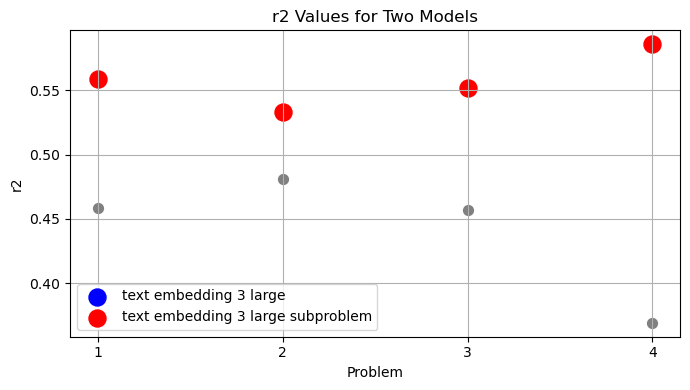

In [2]:
path_emb_1 = "/data/split_by_problem/text_embedding_3_large"
path_emb_2 = "/data/split_by_subproblem/text_embedding_3_large_subproblem"
path_labels_1 = "/data/split_by_problem/latex"
path_labels_2 = "/data/split_by_subproblem/latex"
model_1 = comparison(path_emb_1, path_labels_1, path_emb_2, path_labels_2)
model_1.load_data()
model_1.prepare_data(REMOVE_BAD=True, REMOVE_EMPTY=False)
model_1.clustering(
    metric='cosine',
    linkage_type='complete',
    distance_threshold=None,
    number_of_clusters=40,
    dimensions=12,
    type_of_clustering='Agglomerative',
    type_of_dimension_reduction='PCA',
    type_of_scaler='MinMaxScaler',
)
model_1.analyze([ "r2"], comparing_values="avg", detail=True, plot=True)


Working Directory: /Users/Cyrill/Documents/ETH/Semester FS25/Lab/ethel
Comparing two datasets: text embedding 3 large and text embedding 3 large subproblem
Data loaded successfully.
Data preparation completed.
Clustering completed.
Analyzing data...
             R2_1      R2_2
Problem                    
1        0.433132  0.477451
2        0.435867  0.437815
3        0.422905  0.415482
4        0.441084  0.457837
Weighted average of the r2 values:
text embedding 3 large: 0.433
text embedding 3 large subproblem: 0.447


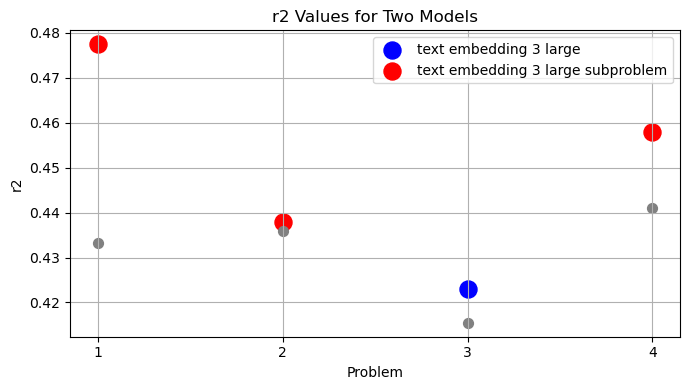

The datasets are not of the same type (Full and Sub). Please check the data.


In [3]:
path_emb_1 = "/data/split_by_problem/text_embedding_3_large"
path_emb_2 = "/data/split_by_subproblem/text_embedding_3_large_subproblem"
path_labels_1 = "/data/split_by_problem/latex"
path_labels_2 = "/data/split_by_subproblem/latex"
model_1 = comparison(path_emb_1, path_labels_1, path_emb_2, path_labels_2)
model_1.load_data()
model_1.prepare_data(REMOVE_BAD=False, REMOVE_EMPTY=False)
model_1.clustering(
    metric='cosine',
    linkage_type='complete',
    distance_threshold=None,
    number_of_clusters=50,
    dimensions=12,
    type_of_clustering='Agglomerative',
    type_of_dimension_reduction='PCA',
    type_of_scaler='MinMaxScaler',
)
model_1.analyze([ "r2"], comparing_values="avg", detail=True, plot=True)
model_1.plotting()


## MathBERT vs original text emb

Working Directory: /Users/Cyrill/Documents/ETH/Semester FS25/Lab/ethel
Comparing two datasets: text embedding 3 large subproblem and MathBERT embeddings
Data loaded successfully.
Data preparation completed.
Clustering completed.
Analyzing data...
Both datasets are of the same type.
             R2_1      R2_2
Problem                    
1a       0.467570  0.332859
1b       0.589563  0.430955
1c       0.471736  0.200885
1d       0.405599  0.402767
1e       0.488553  0.433669
2a       0.380282  0.244134
2b       0.434985  0.342684
2c       0.523206  0.481085
2d       0.424083  0.362066
3a       0.392338  0.215881
3b       0.501272  0.399692
3c       0.380777  0.312355
3d       0.393137  0.363543
4a       0.447183  0.427711
4b       0.412970  0.404566
4c       0.456802  0.381271
4d       0.598390  0.543200
4e       0.370231  0.403710
Weighted average of the r2 values:
text embedding 3 large subproblem: 0.452
MathBERT embeddings: 0.370


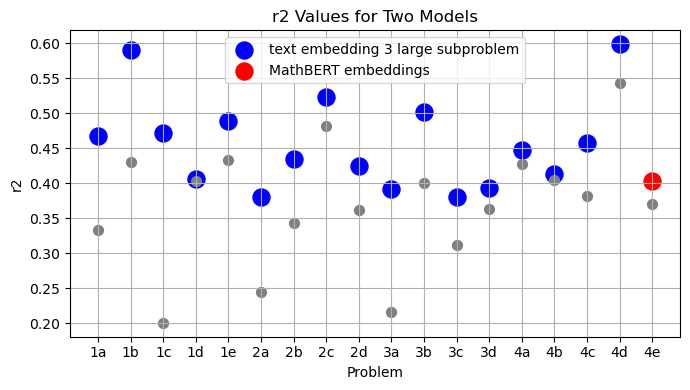

In [4]:
path_emb_1 = "/data/split_by_subproblem/text_embedding_3_large_subproblem"
path_emb_2 = "/data/split_by_subproblem/MathBERT_embeddings"
path_labels_1 = "/data/split_by_subproblem/latex"
path_labels_2 = "/data/split_by_subproblem/latex"
model_2 = comparison(path_emb_1, path_labels_1, path_emb_2, path_labels_2)
model_2.load_data()
model_2.prepare_data(REMOVE_BAD=False, REMOVE_EMPTY=False)
model_2.clustering(
    metric='cosine',
    linkage_type='complete',
    distance_threshold=None,
    number_of_clusters=50,
    dimensions=12,
    type_of_clustering='Agglomerative',
    type_of_dimension_reduction='PCA',
    type_of_scaler='MinMaxScaler',
)
model_2.analyze([ "r2"], comparing_values="min", detail=True, plot=True)

Working Directory: /Users/Cyrill/Documents/ETH/Semester FS25/Lab/ethel
Comparing two datasets: text embedding 3 large subproblem and MathBERT embeddings
Data loaded successfully.
Data preparation completed.
Clustering completed.
Analyzing data...
Both datasets are of the same type.
             R2_1      R2_2
Problem                    
1a       0.431298  0.325945
1b       0.580833  0.425648
1c       0.428783  0.212669
1d       0.571480  0.528528
1e       0.719310  0.659209
2a       0.305266  0.188360
2b       0.476409  0.346989
2c       0.692074  0.632230
2d       0.499102  0.462694
3a       0.417632  0.197192
3b       0.548277  0.446269
3c       0.409378  0.317512
3d       0.641624  0.595673
4a       0.454544  0.409682
4b       0.458472  0.463924
4c       0.590345  0.505739
4d       0.792843  0.688035
4e       0.496655  0.467077
Weighted average of the r2 values:
text embedding 3 large subproblem: 0.526
MathBERT embeddings: 0.434


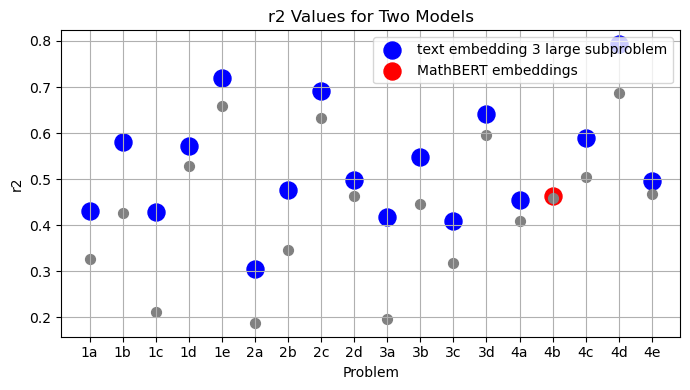

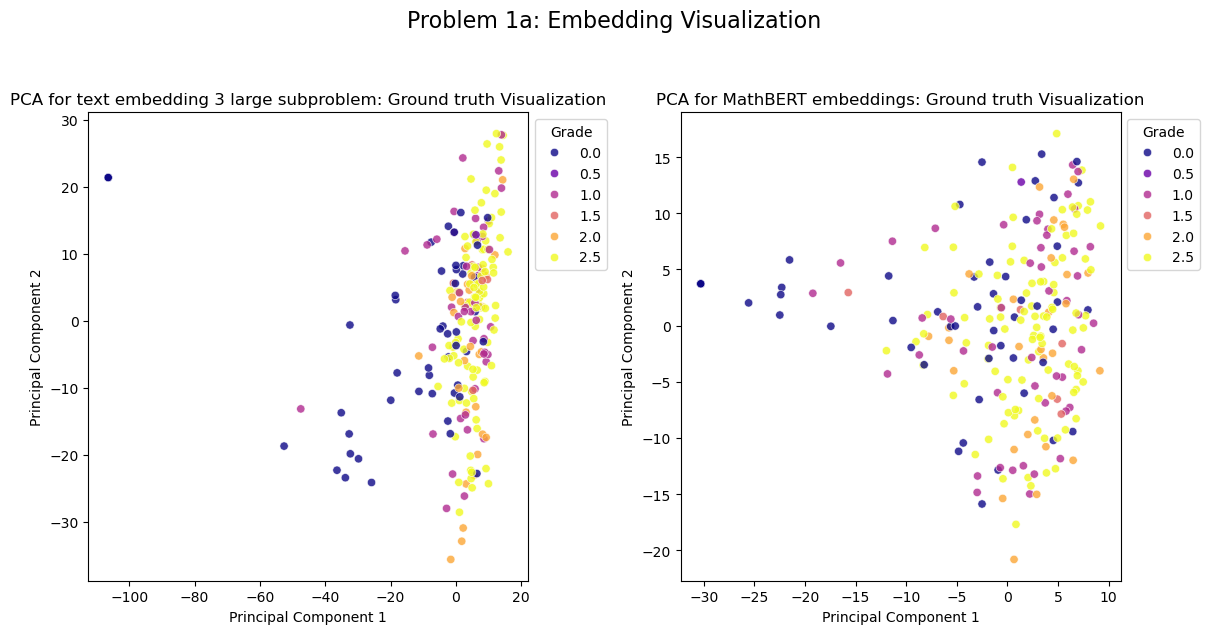

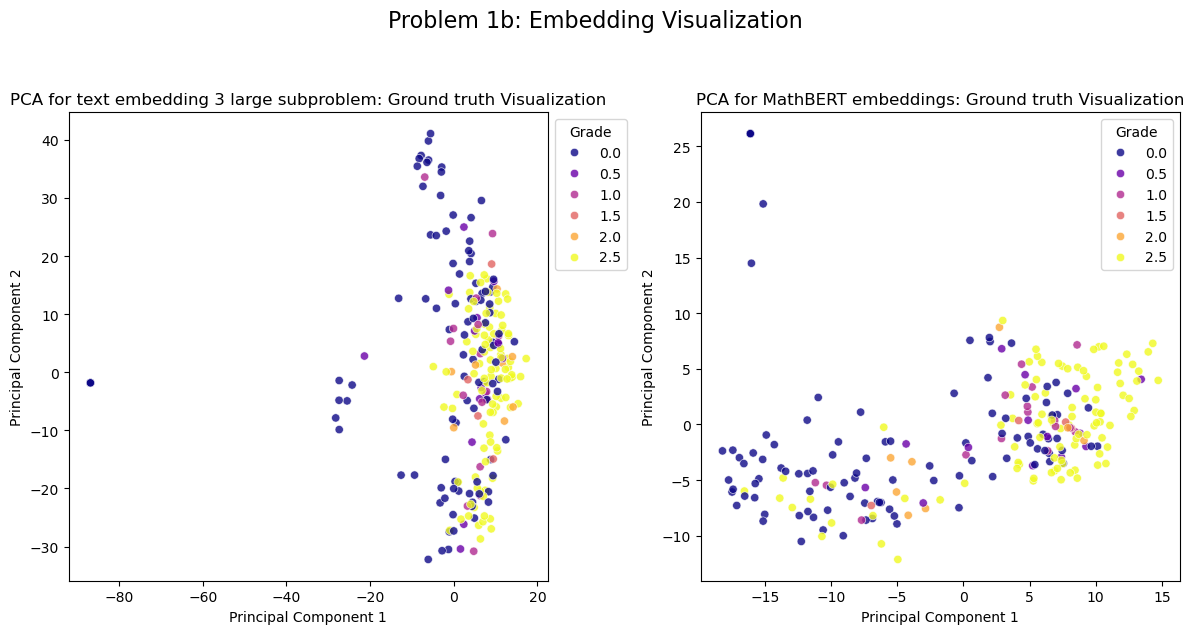

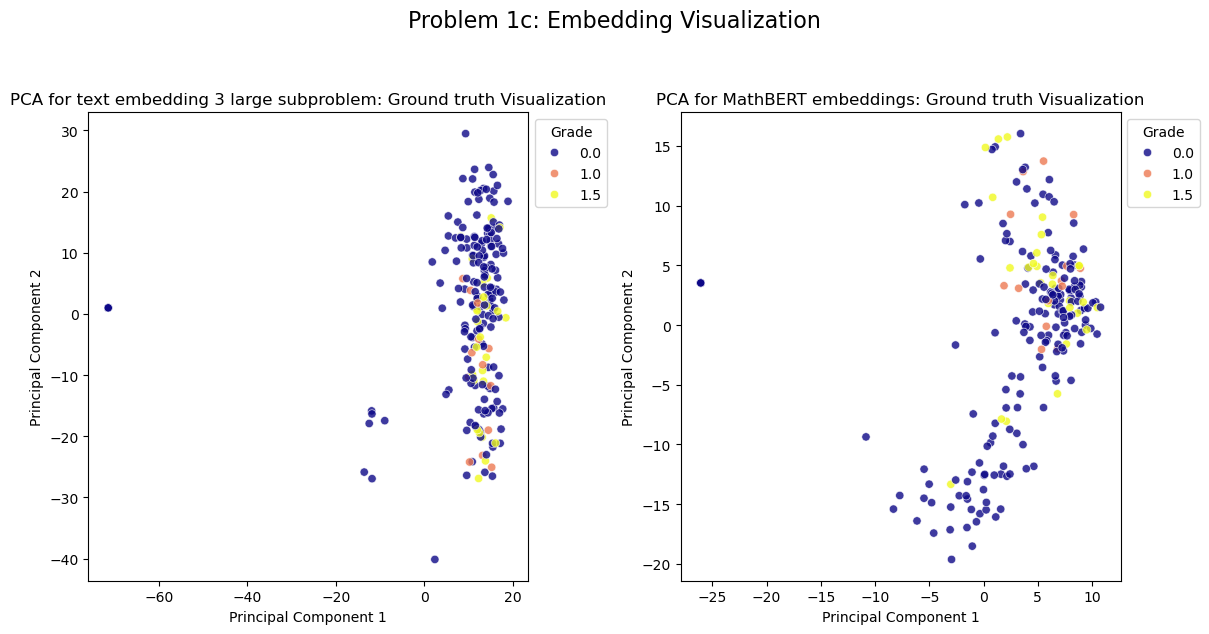

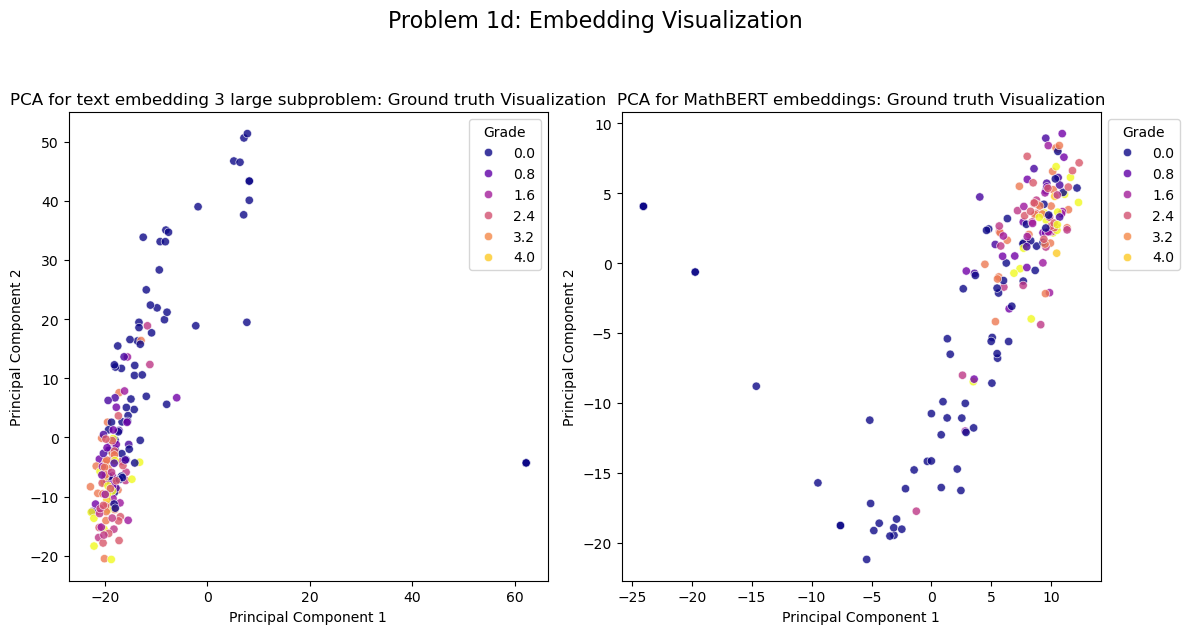

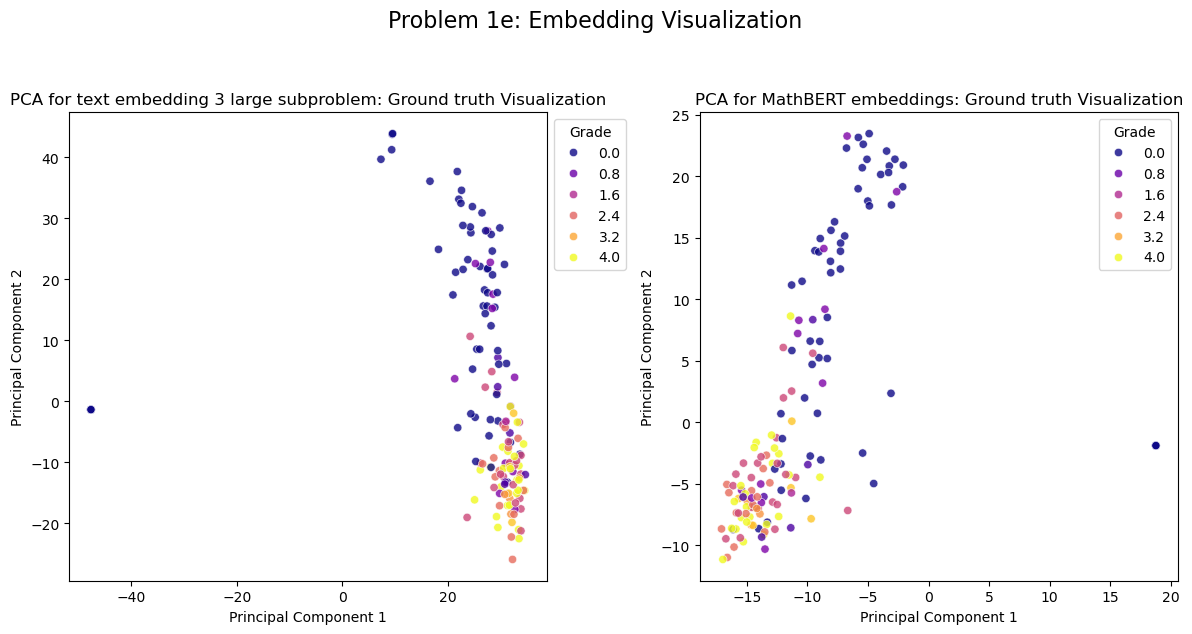

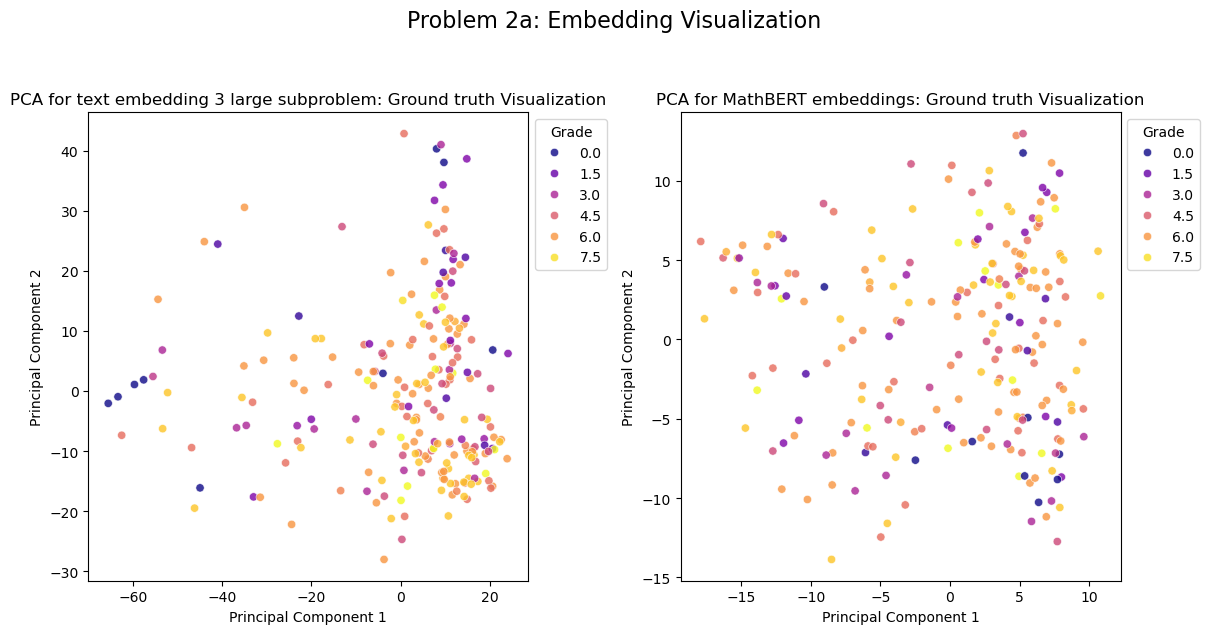

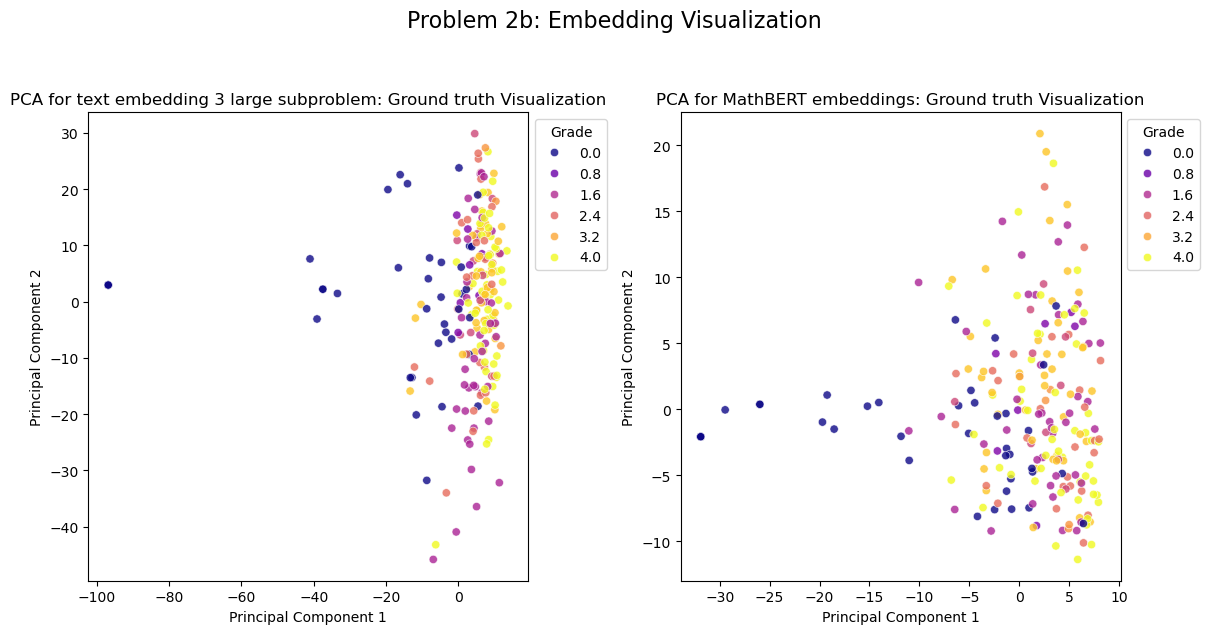

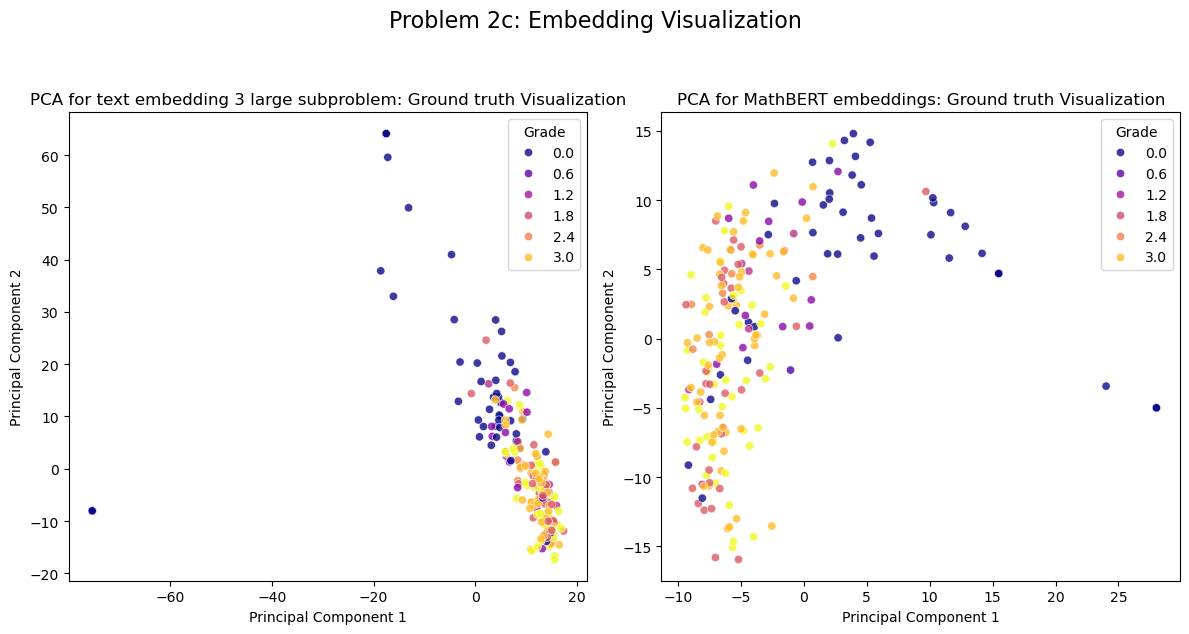

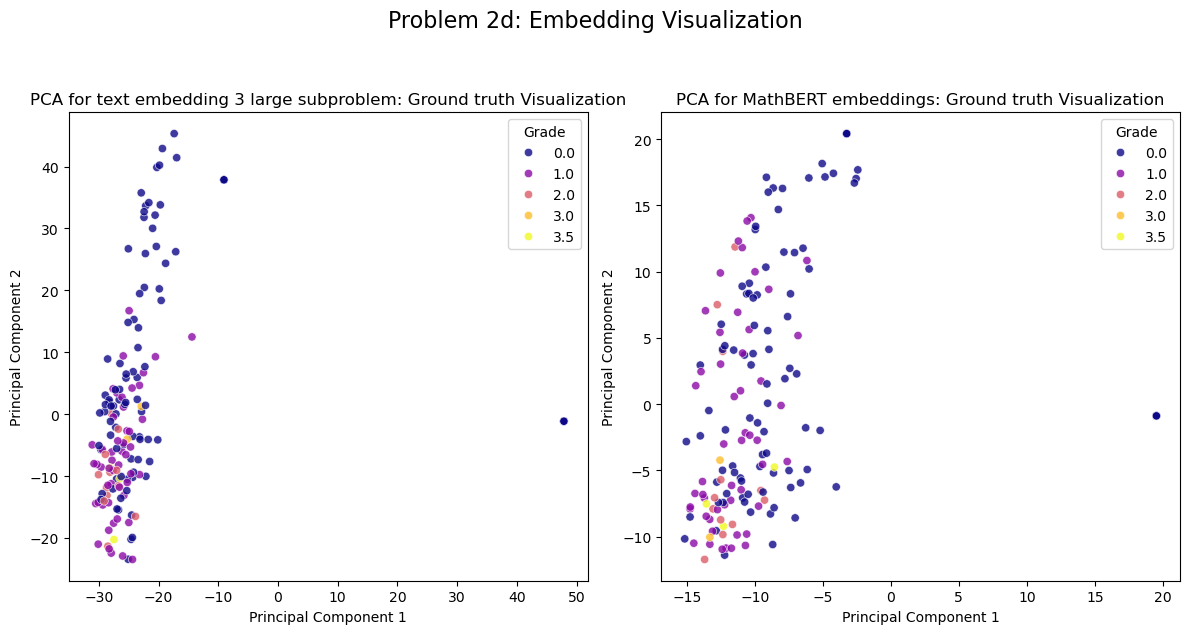

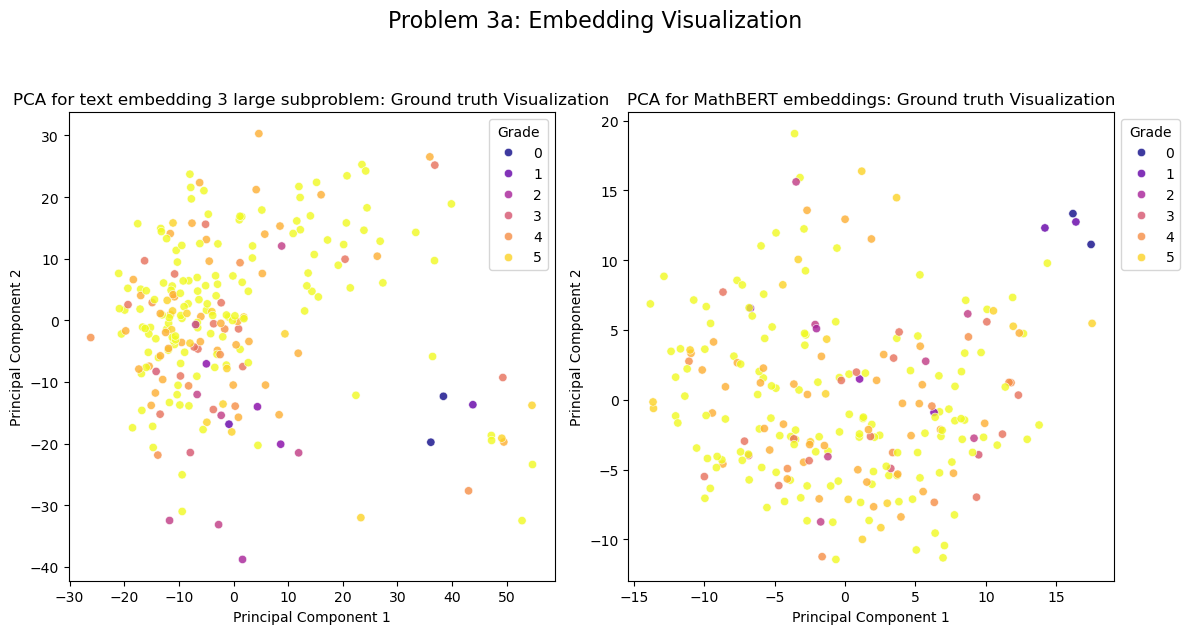

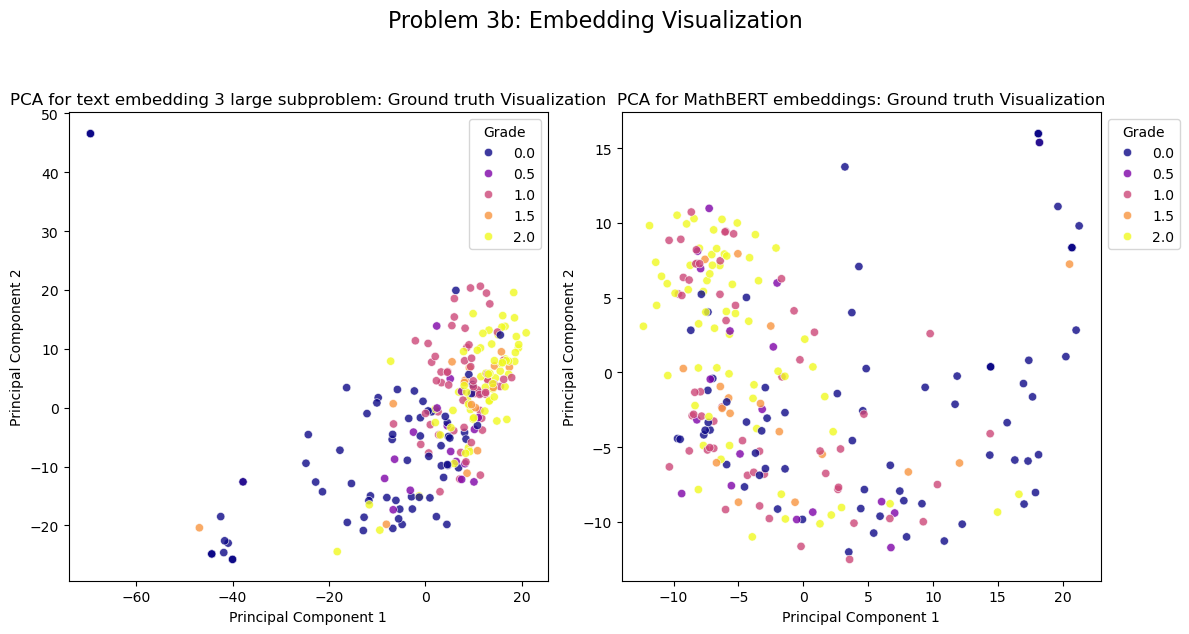

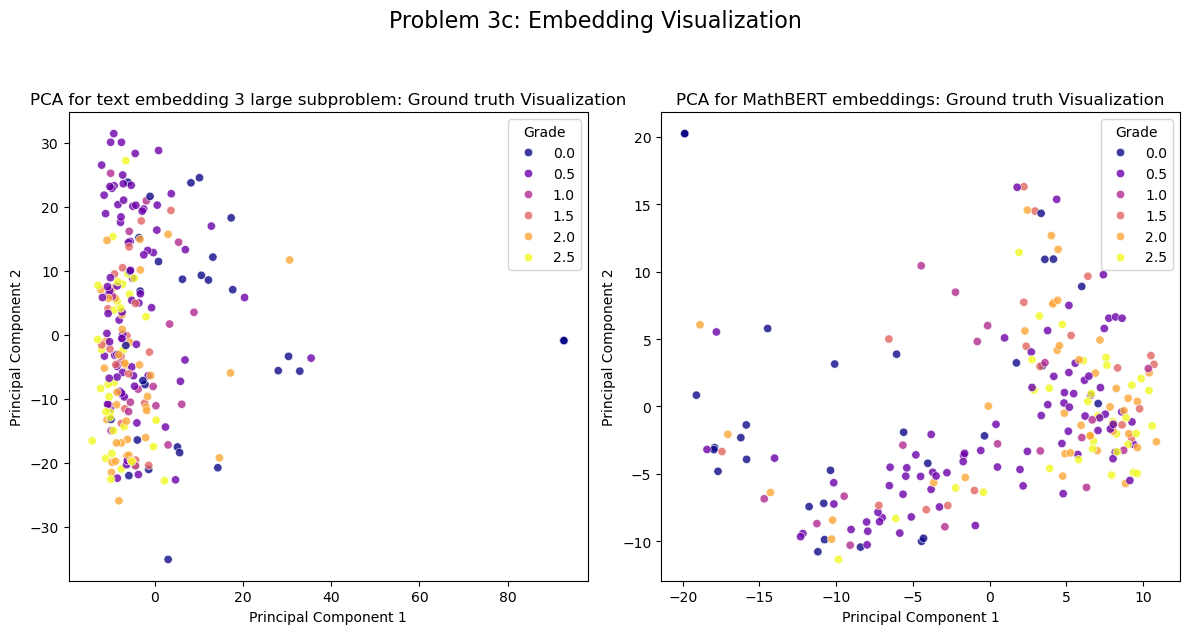

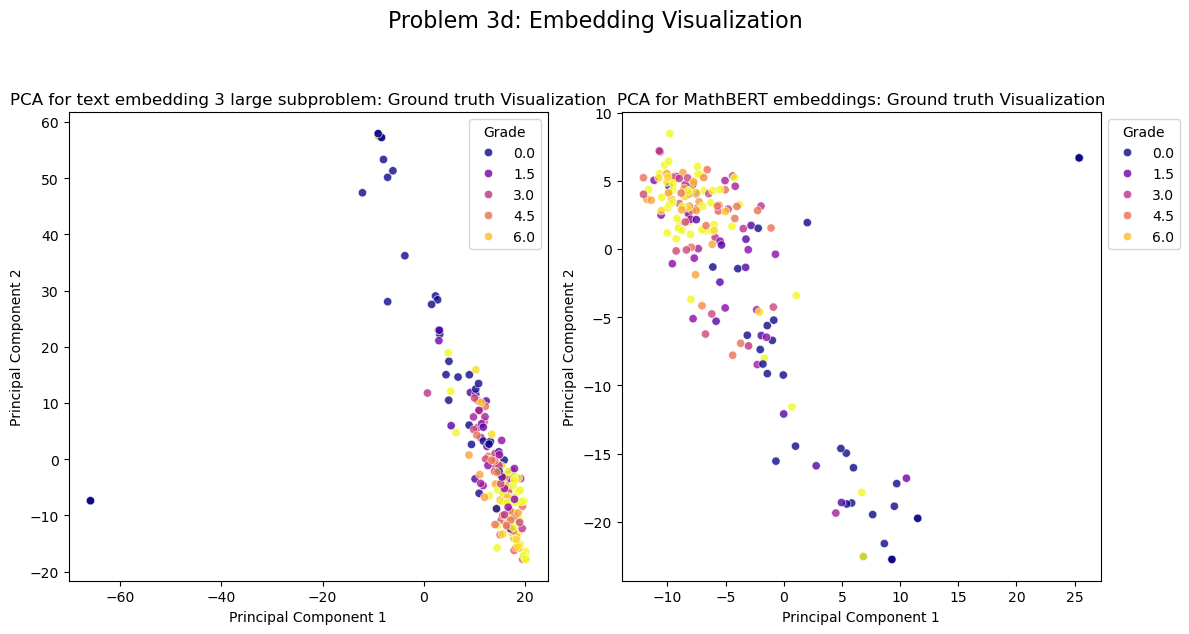

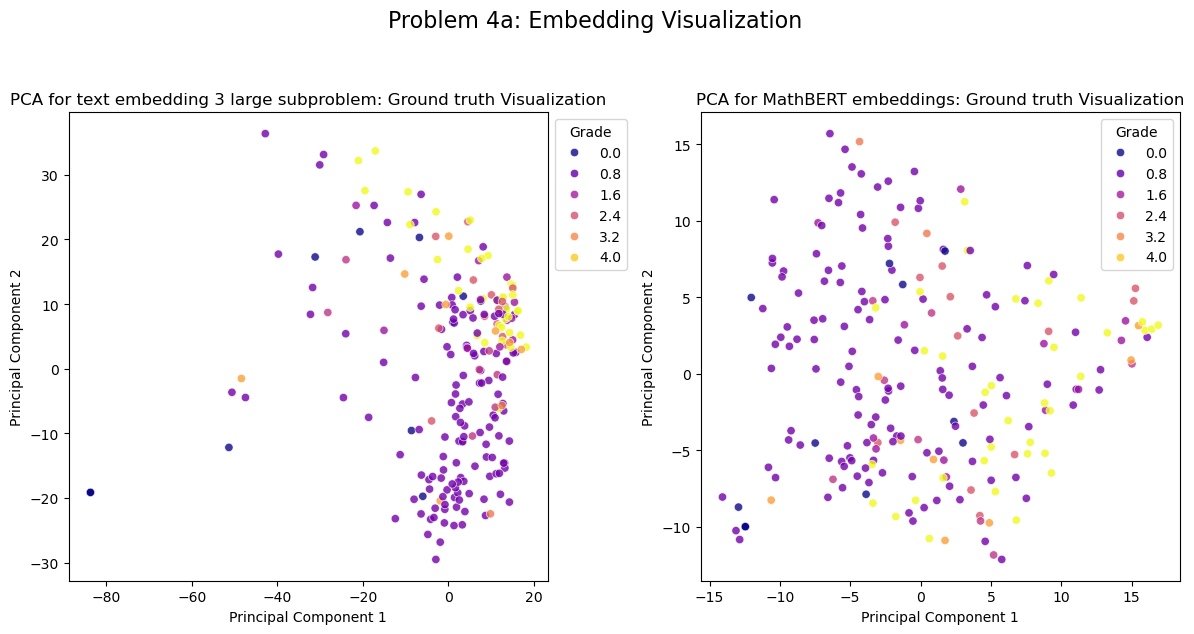

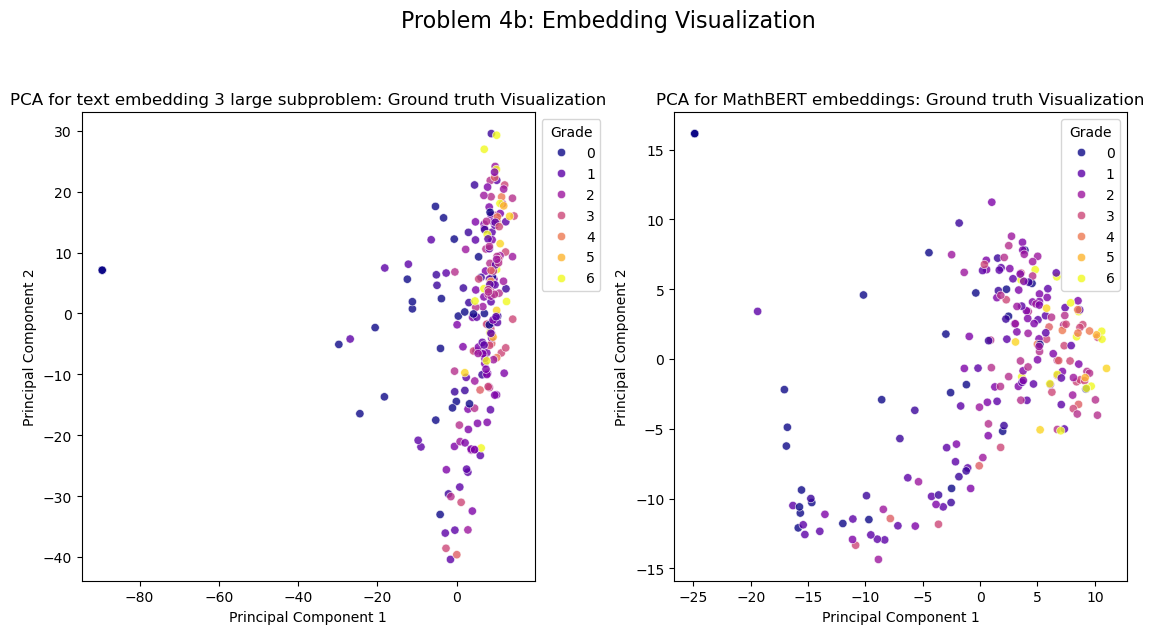

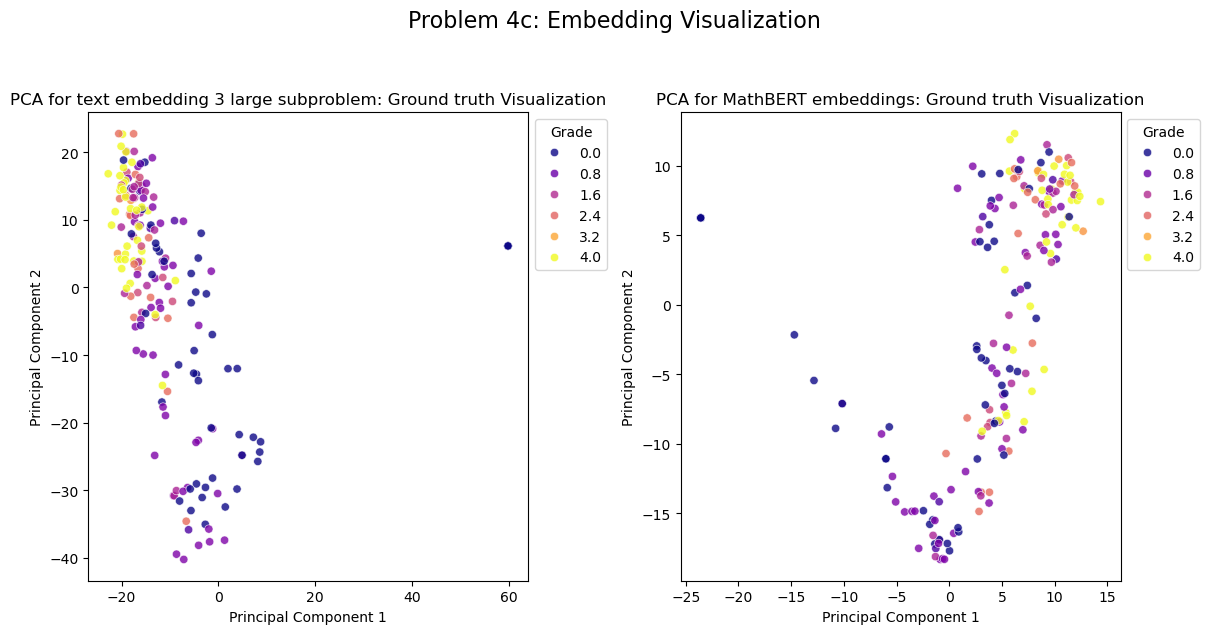

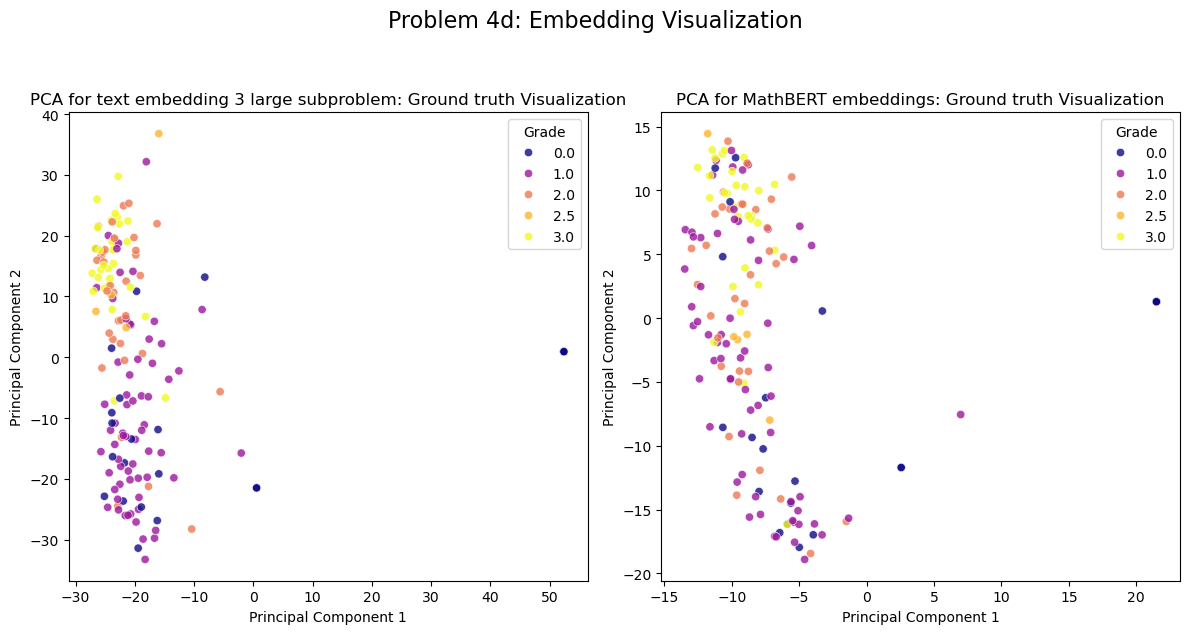

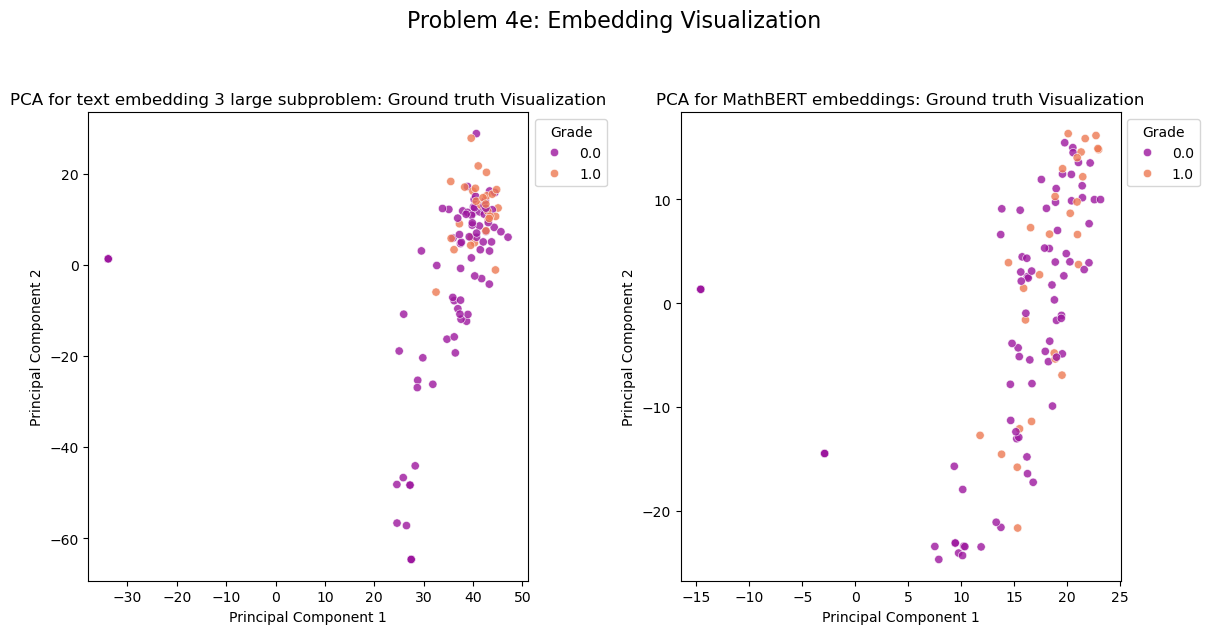

In [5]:
path_emb_1 = "/data/split_by_subproblem/text_embedding_3_large_subproblem"
path_emb_2 = "/data/split_by_subproblem/MathBERT_embeddings"
path_labels_1 = "/data/split_by_subproblem/latex"
path_labels_2 = "/data/split_by_subproblem/latex"
model_2 = comparison(path_emb_1, path_labels_1, path_emb_2, path_labels_2)
model_2.load_data()
model_2.prepare_data(REMOVE_BAD=True, REMOVE_EMPTY=False)
model_2.clustering(
    metric='cosine',
    linkage_type='complete',
    distance_threshold=None,
    number_of_clusters=40,
    dimensions=12,
    type_of_clustering='Agglomerative',
    type_of_dimension_reduction='PCA',
    type_of_scaler='MinMaxScaler',
)
model_2.analyze([ "r2"], comparing_values="min", detail=True, plot=True)
model_2.plotting()

## Text original vs Natural Language

Working Directory: /Users/Cyrill/Documents/ETH/Semester FS25/Lab/ethel
Comparing two datasets: natural language latex embedding 3 large and text embedding 3 large subproblem
Data loaded successfully.
Data preparation completed.
Clustering completed.
Analyzing data...
Both datasets are of the same type.
             R2_1      R2_2
Problem                    
1a       0.439839  0.451790
1b       0.424562  0.589563
1c       0.416390  0.450447
1d       0.413825  0.417344
1e       0.529493  0.488553
2a       0.369657  0.390254
2b       0.479699  0.410223
2c       0.513937  0.523206
2d       0.357245  0.424083
3a       0.251358  0.380009
3b       0.488912  0.505059
3c       0.346883  0.385528
3d       0.387277  0.393137
4a       0.539431  0.448757
4b       0.453812  0.418474
4c       0.488333  0.443642
4d       0.611478  0.598390
4e       0.456541  0.370231
Weighted average of the r2 values:
natural language latex embedding 3 large: 0.442
text embedding 3 large subproblem: 0.449


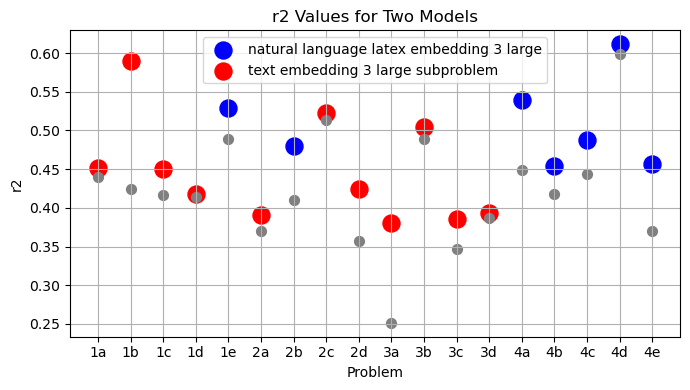

In [6]:
path_emb_2 = "/data/split_by_subproblem/text_embedding_3_large_subproblem"
path_emb_1 = "/data/split_by_subproblem/natural_language_latex_embedding_3_large"
path_labels_2 = "/data/split_by_subproblem/latex"
path_labels_1 = "/data/split_by_subproblem/natural_language_latex"
model_3 = comparison(path_emb_1, path_labels_1, path_emb_2, path_labels_2)
model_3.load_data()
model_3.prepare_data(REMOVE_BAD=False, REMOVE_EMPTY=False)
model_3.clustering(
    metric='cosine',
    linkage_type='complete',
    distance_threshold=None,
    number_of_clusters=50,
    dimensions=12,
    type_of_clustering='Agglomerative',
    type_of_dimension_reduction='PCA',
    type_of_scaler='MinMaxScaler',
)
model_3.analyze([ "r2"], comparing_values="min", detail=True, plot=True)

data_1, data_2 = model_3.get_data()
#count the number of students in each problem
# problem_counts_1 = {key: len(data_1[key]) for key in data_1.keys()}
# problem_counts_2 = {key: len(data_2[key]) for key in data_2.keys()}
# print(problem_counts_1)
# print(problem_counts_2)

Working Directory: /Users/Cyrill/Documents/ETH/Semester FS25/Lab/ethel
Comparing two datasets: natural language latex embedding 3 large and text embedding 3 large subproblem
Data loaded successfully.
Data preparation completed.
Clustering completed.
Analyzing data...
Both datasets are of the same type.
             R2_1      R2_2
Problem                    
1a       0.487943  0.494973
1b       0.444904  0.588687
1c       0.429540  0.383141
1d       0.580684  0.560601
1e       0.788695  0.719310
2a       0.343747  0.298228
2b       0.541187  0.465381
2c       0.645073  0.689064
2d       0.480908  0.499102
3a       0.462827  0.357029
3b       0.567402  0.596881
3c       0.383263  0.485331
3d       0.661738  0.662682
4a       0.497604  0.439061
4b       0.465452  0.409432
4c       0.589175  0.608233
4d       0.784777  0.786932
4e       0.582141  0.496655
Weighted average of the r2 values:
natural language latex embedding 3 large: 0.538
text embedding 3 large subproblem: 0.528


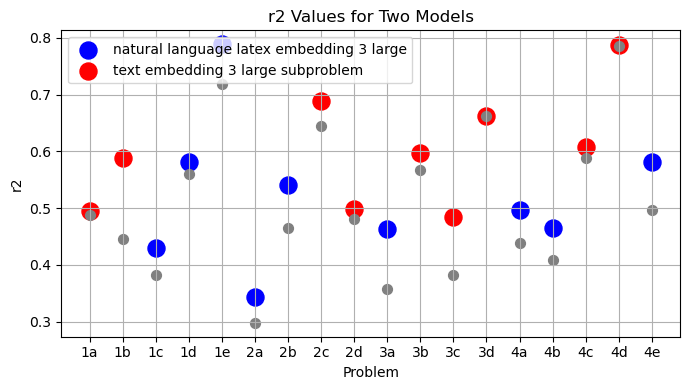

In [7]:
path_emb_2 = "/data/split_by_subproblem/text_embedding_3_large_subproblem"
path_emb_1 = "/data/split_by_subproblem/natural_language_latex_embedding_3_large"
path_labels_2 = "/data/split_by_subproblem/latex"
path_labels_1 = "/data/split_by_subproblem/natural_language_latex"
model_3 = comparison(path_emb_1, path_labels_1, path_emb_2, path_labels_2)
model_3.load_data()
model_3.prepare_data(REMOVE_BAD=True, REMOVE_EMPTY=False)
model_3.clustering(
    metric='cosine',
    linkage_type='complete',
    distance_threshold=None,
    number_of_clusters=40,
    dimensions=12,
    type_of_clustering='Agglomerative',
    type_of_dimension_reduction='PCA',
    type_of_scaler='MinMaxScaler',
)

model_3.analyze([ "r2"], comparing_values="min", detail=True, plot=True)

Working Directory: /Users/Cyrill/Documents/ETH/Semester FS25/Lab/ethel
Comparing two datasets: natural language embedding 3 large and text embedding 3 large subproblem
Data loaded successfully.
Data preparation completed.
Clustering completed.
Analyzing data...
Both datasets are of the same type.
             R2_1      R2_2
Problem                    
1a       0.365250  0.464178
1b       0.303086  0.589563
1c       0.251873  0.471736
1d       0.225683  0.373225
1e       0.190389  0.486576
2a       0.235451  0.381393
2b       0.369332  0.410223
2c       0.287084  0.519343
2d       0.212125  0.412542
3a       0.321878  0.383097
3b       0.496844  0.505059
3c       0.281869  0.380777
3d       0.301258  0.393137
4a       0.453770  0.458453
4b       0.324623  0.411337
4c       0.254738  0.465985
4d       0.232086  0.608430
4e       0.298995  0.370231
Weighted average of the r2 values:
natural language embedding 3 large: 0.300
text embedding 3 large subproblem: 0.449


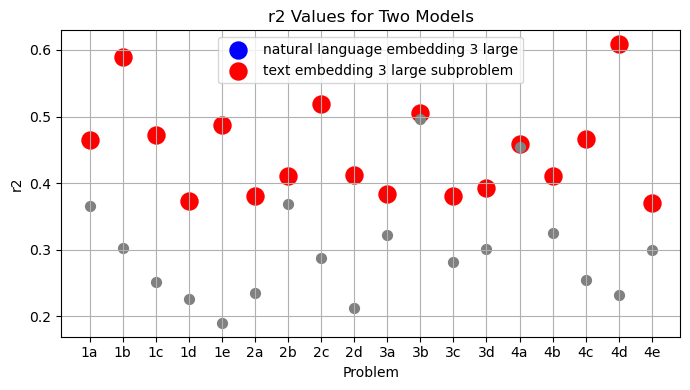

{'problem_1a': 252, 'problem_1b': 252, 'problem_1c': 252, 'problem_1d': 252, 'problem_1e': 252, 'problem_2a': 250, 'problem_2b': 252, 'problem_2c': 251, 'problem_2d': 252, 'problem_3a': 250, 'problem_3b': 251, 'problem_3c': 251, 'problem_3d': 251, 'problem_4a': 238, 'problem_4b': 238, 'problem_4c': 238, 'problem_4d': 238, 'problem_4e': 238}
{'problem_1a': 252, 'problem_1b': 252, 'problem_1c': 252, 'problem_1d': 252, 'problem_1e': 252, 'problem_2a': 250, 'problem_2b': 252, 'problem_2c': 251, 'problem_2d': 252, 'problem_3a': 250, 'problem_3b': 251, 'problem_3c': 251, 'problem_3d': 251, 'problem_4a': 238, 'problem_4b': 238, 'problem_4c': 238, 'problem_4d': 238, 'problem_4e': 238}


In [8]:
path_emb_1 = "/data/split_by_subproblem/natural_language_embedding_3_large"
path_emb_2 = "/data/split_by_subproblem/text_embedding_3_large_subproblem"
path_labels_2 = "/data/split_by_subproblem/natural_language"
path_labels_1 = "/data/split_by_subproblem/latex"
model_4 = comparison(path_emb_1, path_labels_1, path_emb_2, path_labels_2)
model_4.load_data()
model_4.prepare_data(REMOVE_BAD=False, REMOVE_EMPTY=False)
model_4.clustering(
    metric='cosine',
    linkage_type='complete',
    distance_threshold=None,
    number_of_clusters=50,
    dimensions=12,
    type_of_clustering='Agglomerative',
    type_of_dimension_reduction='PCA',
    type_of_scaler='MinMaxScaler',
)

model_4.analyze([ "r2"], comparing_values="min", detail=True, plot=True)

data_1, data_2 = model_4.get_data()
#count the number of students in each problem
problem_counts_1 = {key: len(data_1[key]) for key in data_1.keys()}
problem_counts_2 = {key: len(data_2[key]) for key in data_2.keys()}
print(problem_counts_1)
print(problem_counts_2)

Working Directory: /Users/Cyrill/Documents/ETH/Semester FS25/Lab/ethel
Comparing two datasets: natural language embedding 3 large and text embedding 3 large subproblem
Data loaded successfully.
Data preparation completed.
Clustering completed.
Analyzing data...
Both datasets are of the same type.
             R2_1      R2_2
Problem                    
1a       0.357035  0.500358
1b       0.579165  0.544135
1c       0.392603  0.359303
1d       0.680692  0.583818
1e       0.962757  0.711898
2a       0.268332  0.340833
2b       0.532793  0.513229
2c       0.854714  0.748712
2d       0.835184  0.391555
3a       0.441321  0.370381
3b       0.674787  0.542907
3c       0.356539  0.466412
3d       0.568228  0.691620
4a       0.585714  0.519497
4b       0.481026  0.490229
4c       0.746746  0.626267
4d       0.866106  0.894585
4e       0.872121  0.414955
Weighted average of the r2 values:
natural language embedding 3 large: 0.592
text embedding 3 large subproblem: 0.520


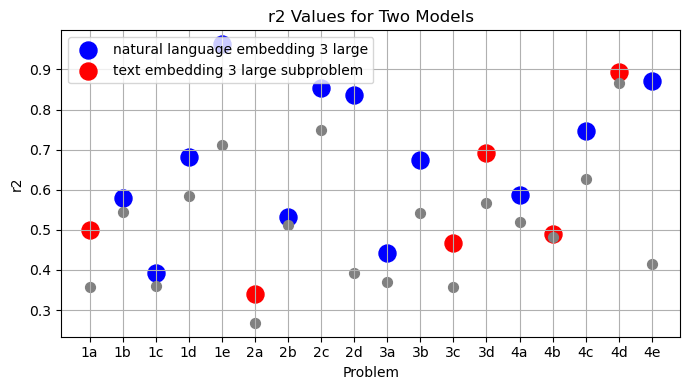

{'problem_1a': 233, 'problem_1b': 199, 'problem_1c': 230, 'problem_1d': 150, 'problem_1e': 163, 'problem_2a': 220, 'problem_2b': 199, 'problem_2c': 134, 'problem_2d': 188, 'problem_3a': 224, 'problem_3b': 215, 'problem_3c': 200, 'problem_3d': 167, 'problem_4a': 186, 'problem_4b': 173, 'problem_4c': 139, 'problem_4d': 142, 'problem_4e': 211}
{'problem_1a': 233, 'problem_1b': 199, 'problem_1c': 230, 'problem_1d': 150, 'problem_1e': 163, 'problem_2a': 220, 'problem_2b': 199, 'problem_2c': 134, 'problem_2d': 188, 'problem_3a': 224, 'problem_3b': 215, 'problem_3c': 200, 'problem_3d': 167, 'problem_4a': 186, 'problem_4b': 173, 'problem_4c': 139, 'problem_4d': 142, 'problem_4e': 211}


In [9]:
path_emb_1 = "/data/split_by_subproblem/natural_language_embedding_3_large"
path_emb_2 = "/data/split_by_subproblem/text_embedding_3_large_subproblem"
path_labels_2 = "/data/split_by_subproblem/natural_language"
path_labels_1 = "/data/split_by_subproblem/latex"
model_4 = comparison(path_emb_1, path_labels_1, path_emb_2, path_labels_2)
model_4.load_data()
model_4.prepare_data(REMOVE_BAD=True, REMOVE_EMPTY=False)
model_4.clustering(
    metric='cosine',
    linkage_type='complete',
    distance_threshold=None,
    number_of_clusters=40,
    dimensions=12,
    type_of_clustering='Agglomerative',
    type_of_dimension_reduction='PCA',
    type_of_scaler='MinMaxScaler',
)

model_4.analyze([ "r2"], comparing_values="min", detail=True, plot=True)

data_1, data_2 = model_4.get_data()
#count the number of students in each problem
problem_counts_1 = {key: len(data_1[key]) for key in data_1.keys()}
problem_counts_2 = {key: len(data_2[key]) for key in data_2.keys()}
print(problem_counts_1)
print(problem_counts_2)

### Natural language vs natlan latex

Working Directory: /Users/Cyrill/Documents/ETH/Semester FS25/Lab/ethel
Comparing two datasets: natural language embedding 3 large and natural language latex embedding 3 large
Data loaded successfully.
Data preparation completed.
Clustering completed.
Analyzing data...
Both datasets are of the same type.
             R2_1      R2_2
Problem                    
1a       0.366000  0.500406
1b       0.591931  0.486762
1c       0.399689  0.343012
1d       0.680692  0.678520
1e       0.962757  0.851574
2a       0.306031  0.309346
2b       0.533605  0.543338
2c       0.854714  0.764768
2d       0.830606  0.473505
3a       0.441321  0.409980
3b       0.662695  0.592099
3c       0.356539  0.375845
3d       0.540013  0.728375
4a       0.581455  0.530456
4b       0.481026  0.554783
4c       0.746746  0.747006
4d       0.866106  0.880619
4e       0.872121  0.611035
Weighted average of the r2 values:
natural language embedding 3 large: 0.594
natural language latex embedding 3 large: 0.554


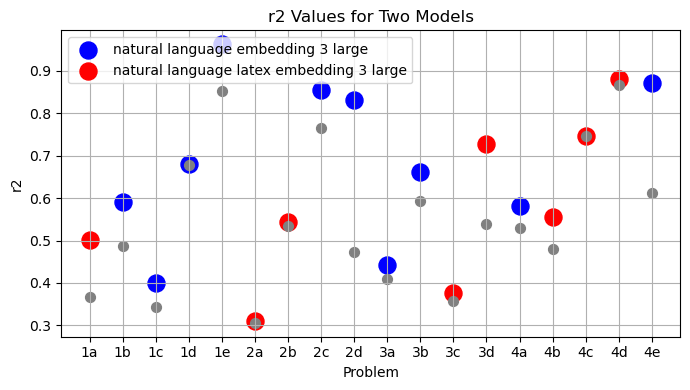

{'problem_1a': 232, 'problem_1b': 199, 'problem_1c': 230, 'problem_1d': 150, 'problem_1e': 163, 'problem_2a': 218, 'problem_2b': 199, 'problem_2c': 134, 'problem_2d': 188, 'problem_3a': 224, 'problem_3b': 213, 'problem_3c': 200, 'problem_3d': 167, 'problem_4a': 185, 'problem_4b': 173, 'problem_4c': 139, 'problem_4d': 142, 'problem_4e': 211}
{'problem_1a': 232, 'problem_1b': 199, 'problem_1c': 230, 'problem_1d': 150, 'problem_1e': 163, 'problem_2a': 218, 'problem_2b': 199, 'problem_2c': 134, 'problem_2d': 188, 'problem_3a': 224, 'problem_3b': 213, 'problem_3c': 200, 'problem_3d': 167, 'problem_4a': 185, 'problem_4b': 173, 'problem_4c': 139, 'problem_4d': 142, 'problem_4e': 211}


In [10]:
path_emb_1 = "/data/split_by_subproblem/natural_language_embedding_3_large"
path_emb_2 = "/data/split_by_subproblem/natural_language_latex_embedding_3_large"
path_labels_2 = "/data/split_by_subproblem/natural_language"
path_labels_1 = "/data/split_by_subproblem/natural_language_latex"
model_4 = comparison(path_emb_1, path_labels_1, path_emb_2, path_labels_2)
model_4.load_data()
model_4.prepare_data(REMOVE_BAD=True, REMOVE_EMPTY=False)
model_4.clustering(
    metric='cosine',
    linkage_type='complete',
    distance_threshold=None,
    number_of_clusters=40,
    dimensions=12,
    type_of_clustering='Agglomerative',
    type_of_dimension_reduction='PCA',
    type_of_scaler='MinMaxScaler',
)

model_4.analyze([ "r2"], comparing_values="min", detail=True, plot=True)

data_1, data_2 = model_4.get_data()
#count the number of students in each problem
problem_counts_1 = {key: len(data_1[key]) for key in data_1.keys()}
problem_counts_2 = {key: len(data_2[key]) for key in data_2.keys()}
print(problem_counts_1)
print(problem_counts_2)

Working Directory: /Users/Cyrill/Documents/ETH/Semester FS25/Lab/ethel
Comparing two datasets: natural language latex embedding 3 large and natural language embedding 3 large
Data loaded successfully.
Data preparation completed.
Clustering completed.
Analyzing data...
Both datasets are of the same type.
             R2_1      R2_2
Problem                    
1a       0.439839  0.365250
1b       0.424562  0.285531
1c       0.416390  0.251873
1d       0.413825  0.225683
1e       0.529493  0.190389
2a       0.389856  0.232250
2b       0.478156  0.356966
2c       0.507576  0.290249
2d       0.339382  0.212125
3a       0.279137  0.295940
3b       0.488763  0.496844
3c       0.346883  0.281869
3d       0.400011  0.301258
4a       0.508066  0.440789
4b       0.453812  0.324623
4c       0.488333  0.254738
4d       0.614096  0.232086
4e       0.472198  0.298995
Weighted average of the r2 values:
natural language latex embedding 3 large: 0.443
natural language embedding 3 large: 0.296


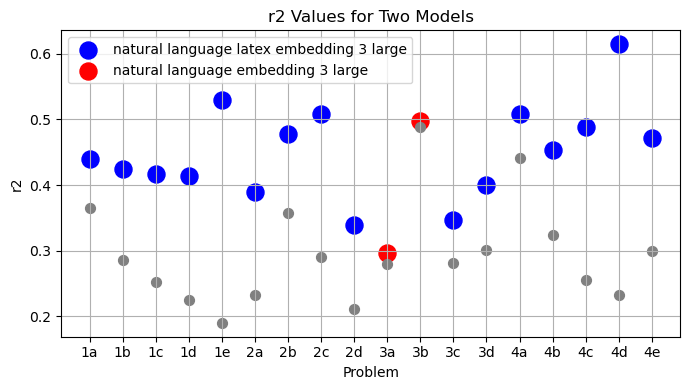

{'problem_1a': 252, 'problem_1b': 252, 'problem_1c': 252, 'problem_1d': 252, 'problem_1e': 252, 'problem_2a': 250, 'problem_2b': 252, 'problem_2c': 251, 'problem_2d': 252, 'problem_3a': 250, 'problem_3b': 251, 'problem_3c': 251, 'problem_3d': 251, 'problem_4a': 238, 'problem_4b': 238, 'problem_4c': 238, 'problem_4d': 238, 'problem_4e': 238}
{'problem_1a': 252, 'problem_1b': 252, 'problem_1c': 252, 'problem_1d': 252, 'problem_1e': 252, 'problem_2a': 250, 'problem_2b': 252, 'problem_2c': 251, 'problem_2d': 252, 'problem_3a': 250, 'problem_3b': 251, 'problem_3c': 251, 'problem_3d': 251, 'problem_4a': 238, 'problem_4b': 238, 'problem_4c': 238, 'problem_4d': 238, 'problem_4e': 238}


In [11]:
path_emb_2 = "/data/split_by_subproblem/natural_language_embedding_3_large"
path_emb_1 = "/data/split_by_subproblem/natural_language_latex_embedding_3_large"
path_labels_1 = "/data/split_by_subproblem/natural_language"
path_labels_2 = "/data/split_by_subproblem/natural_language_latex"
model_4 = comparison(path_emb_1, path_labels_1, path_emb_2, path_labels_2)
model_4.load_data()
model_4.prepare_data(REMOVE_BAD=False, REMOVE_EMPTY=False)
model_4.clustering(
    metric='cosine',
    linkage_type='complete',
    distance_threshold=None,
    number_of_clusters=50,
    dimensions=12,
    type_of_clustering='Agglomerative',
    type_of_dimension_reduction='PCA',
    type_of_scaler='MinMaxScaler',
)

model_4.analyze([ "r2"], comparing_values="min", detail=True, plot=True)
data_1, data_2 = model_4.get_data()
problem_counts_1 = {key: len(data_1[key]) for key in data_1.keys()}
problem_counts_2 = {key: len(data_2[key]) for key in data_2.keys()}
print(problem_counts_1)
print(problem_counts_2)

# Context vs No Context

Working Directory: /Users/Cyrill/Documents/ETH/Semester FS25/Lab/ethel
Comparing two datasets: NL with context embedding 3 large and natural language embedding 3 large
Data loaded successfully.
Data preparation completed.
Clustering completed.
Analyzing data...
Both datasets are of the same type.
             R2_1      R2_2
Problem                    
1a       0.387539  0.320511
1b       0.574920  0.586505
1c       0.374660  0.442768
1d       0.667947  0.661910
1e       0.641823  0.976740
2a       0.355785  0.220721
2b       0.591809  0.496705
2c       0.746144  0.804263
2d       0.442764  0.834496
3a       0.372500  0.349490
3b       0.741894  0.705364
3c       0.438635  0.402521
3d       0.730394  0.605069
4a       0.576565  0.581326
4b       0.456710  0.481744
4c       0.694156  0.774476
4d       0.836060  0.851865
4e       0.468628  0.838533
Weighted average of the r2 values:
NL with context embedding 3 large: 0.542
natural language embedding 3 large: 0.583


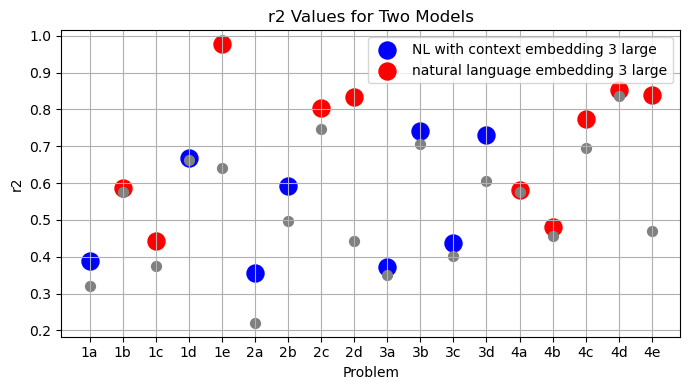

{'problem_1a': 249, 'problem_1b': 197, 'problem_1c': 231, 'problem_1d': 157, 'problem_1e': 166, 'problem_2a': 243, 'problem_2b': 212, 'problem_2c': 148, 'problem_2d': 191, 'problem_3a': 235, 'problem_3b': 221, 'problem_3c': 212, 'problem_3d': 177, 'problem_4a': 208, 'problem_4b': 190, 'problem_4c': 152, 'problem_4d': 151, 'problem_4e': 223}
{'problem_1a': 249, 'problem_1b': 197, 'problem_1c': 231, 'problem_1d': 157, 'problem_1e': 166, 'problem_2a': 243, 'problem_2b': 212, 'problem_2c': 148, 'problem_2d': 191, 'problem_3a': 235, 'problem_3b': 221, 'problem_3c': 212, 'problem_3d': 177, 'problem_4a': 208, 'problem_4b': 190, 'problem_4c': 152, 'problem_4d': 151, 'problem_4e': 223}


In [12]:
path_emb_1 = "/data/split_by_subproblem/NL_with_context_embedding_3_large"
path_emb_2 = "/data/split_by_subproblem/natural_language_embedding_3_large"
path_labels_1 = "/data/split_by_subproblem/NL_with_context"
path_labels_2 = "/data/split_by_subproblem/natural_language"
model_5 = comparison(path_emb_1, path_labels_1, path_emb_2, path_labels_2)
model_5.load_data()
model_5.prepare_data(REMOVE_BAD=True, REMOVE_EMPTY=False)
model_5.clustering(
    metric='cosine',
    linkage_type='complete',
    distance_threshold=None,
    number_of_clusters=40,
    dimensions=12,
    type_of_clustering='Agglomerative',
    type_of_dimension_reduction='PCA',
    type_of_scaler='MinMaxScaler',
)

model_5.analyze([ "r2"], comparing_values="min", detail=True, plot=True)
data_1, data_2 = model_5.get_data()
#count the number of students in each problem
problem_counts_1 = {key: len(data_1[key]) for key in data_1.keys()}
problem_counts_2 = {key: len(data_2[key]) for key in data_2.keys()}
print(problem_counts_1)
print(problem_counts_2)

Working Directory: /Users/Cyrill/Documents/ETH/Semester FS25/Lab/ethel
Comparing two datasets: NL with context embedding 3 large and natural language embedding 3 large
Data loaded successfully.
Data preparation completed.
Clustering completed.
Analyzing data...
Both datasets are of the same type.
             R2_1      R2_2
Problem                    
1a       0.413228  0.356695
1b       0.469133  0.290740
1c       0.406346  0.213637
1d       0.508561  0.222509
1e       0.641549  0.190389
2a       0.347275  0.236580
2b       0.549406  0.357893
2c       0.619872  0.287084
2d       0.492216  0.212125
3a       0.401814  0.286726
3b       0.637683  0.499631
3c       0.405864  0.254862
3d       0.523209  0.300486
4a       0.552828  0.438443
4b       0.386415  0.349771
4c       0.449463  0.276035
4d       0.525894  0.231519
4e       0.584397  0.277123
Weighted average of the r2 values:
NL with context embedding 3 large: 0.495
natural language embedding 3 large: 0.293


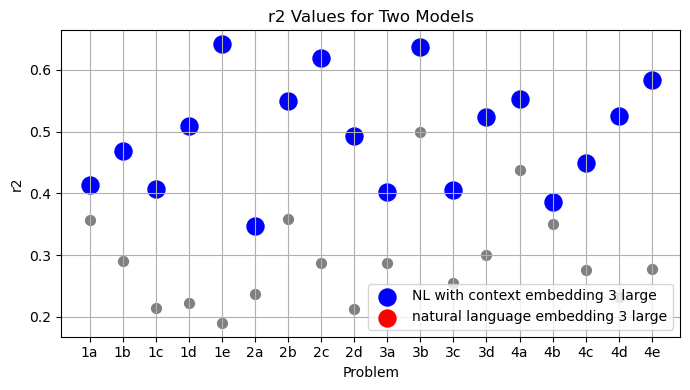

In [18]:
path_emb_1 = "/data/split_by_subproblem/NL_with_context_embedding_3_large"
path_emb_2 = "/data/split_by_subproblem/natural_language_embedding_3_large"
path_labels_1 = "/data/split_by_subproblem/NL_with_context"
path_labels_2 = "/data/split_by_subproblem/natural_language"
model_5 = comparison(path_emb_1, path_labels_1, path_emb_2, path_labels_2)
model_5.load_data()
model_5.prepare_data(REMOVE_BAD=False, REMOVE_EMPTY=False)
model_5.clustering(
    metric='cosine',
    linkage_type='complete',
    distance_threshold=None,
    number_of_clusters=50,
    dimensions=12,
    type_of_clustering='Agglomerative',
    type_of_dimension_reduction='PCA',
    type_of_scaler='MinMaxScaler',
)

model_5.analyze([ "r2"], comparing_values="min", detail=True, plot=True)

### with interpretation

Working Directory: /Users/Cyrill/Documents/ETH/Semester FS25/Lab/ethel
Comparing two datasets: NL with context and interpretation embedding 3 large and natural language embedding 3 large
Data loaded successfully.
Data preparation completed.
Clustering completed.
Analyzing data...
Both datasets are of the same type.
             R2_1      R2_2
Problem                    
1a       0.440457  0.317011
1b       0.476862  0.579232
1c       0.438574  0.444799
1d       0.719566  0.693623
1e       0.696950  0.974664
2a       0.291867  0.220442
2b       0.560669  0.478854
2c       0.808055  0.804263
2d       0.674181  0.765872
3a       0.395383  0.359694
3b       0.654587  0.679996
3c       0.409610  0.385101
3d       0.736547  0.581270
4a       0.551436  0.556147
4b       0.433852  0.482216
4c       0.696262  0.751320
4d       0.830736  0.825710
4e       0.530279  0.838533
Weighted average of the r2 values:
NL with context and interpretation embedding 3 large: 0.554
natural language embedding 3

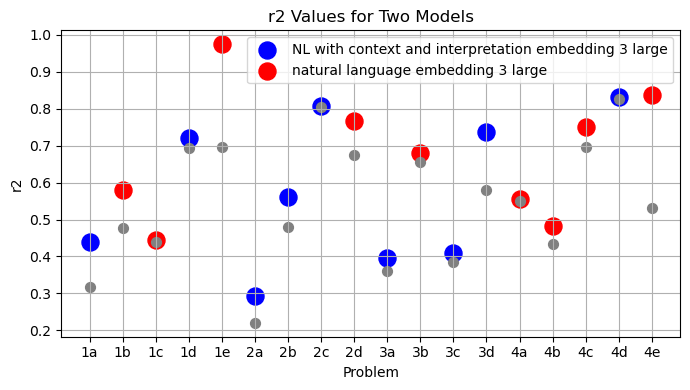

In [22]:
path_emb_1 = "/data/split_by_subproblem/NL_with_context_and_interpretation_embedding_3_large"
path_emb_2 = "/data/split_by_subproblem/natural_language_embedding_3_large"
path_labels_2 = "/data/split_by_subproblem/NL_with_context_and_interpretation"
path_labels_1 = "/data/split_by_subproblem/natural_language"
model_5 = comparison(path_emb_1, path_labels_1, path_emb_2, path_labels_2)
model_5.load_data()
model_5.prepare_data(REMOVE_BAD=True, REMOVE_EMPTY=False)
model_5.clustering(
    metric='cosine',
    linkage_type='complete',
    distance_threshold=None,
    number_of_clusters=40,
    dimensions=12,
    type_of_clustering='Agglomerative',
    type_of_dimension_reduction='PCA',
    type_of_scaler='MinMaxScaler',
)

model_5.analyze([ "r2"], comparing_values="min", detail=True, plot=True)
# data_1, data_2 = model_5.get_data()
# df = data_1['problem_1e']
# model_5.plotting()
# print(df['Embedding'].apply(lambda x: tuple(x)).nunique())
# print(df["Embedding"].count())
# #count the number of students in each problem
# problem_counts_1 = {key: len(data_1[key]) for key in data_1.keys()}
# problem_counts_2 = {key: len(data_2[key]) for key in data_2.keys()}
# print(problem_counts_1)
# print(problem_counts_2)

Working Directory: /Users/Cyrill/Documents/ETH/Semester FS25/Lab/ethel
Comparing two datasets: NL with context and interpretation embedding 3 large and natural language embedding 3 large
Data loaded successfully.
Data preparation completed.
Clustering completed.
Analyzing data...
Both datasets are of the same type.
             R2_1      R2_2
Problem                    
1a       0.429922  0.356695
1b       0.469802  0.290740
1c       0.458460  0.213637
1d       0.538845  0.222509
1e       0.667694  0.190389
2a       0.356316  0.236580
2b       0.501500  0.357893
2c       0.627569  0.287084
2d       0.543342  0.212125
3a       0.369380  0.286726
3b       0.601240  0.499631
3c       0.401680  0.254862
3d       0.529144  0.300486
4a       0.569592  0.438443
4b       0.453035  0.349771
4c       0.612709  0.276035
4d       0.686443  0.231519
4e       0.515408  0.277123
Weighted average of the r2 values:
NL with context and interpretation embedding 3 large: 0.519
natural language embedding 3

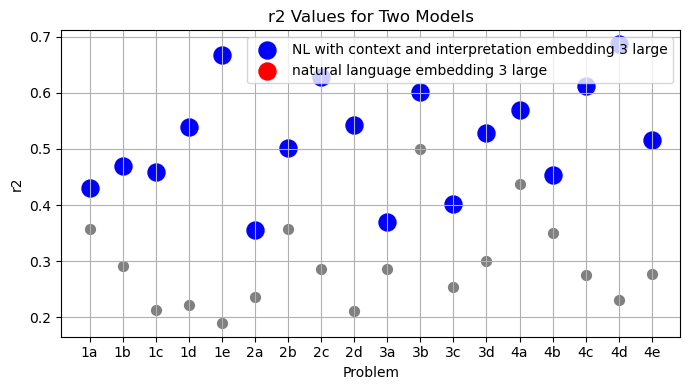

In [21]:
path_emb_1 = "/data/split_by_subproblem/NL_with_context_and_interpretation_embedding_3_large"
path_emb_2 = "/data/split_by_subproblem/natural_language_embedding_3_large"
path_labels_2 = "/data/split_by_subproblem/NL_with_context_and_interpretation"
path_labels_1 = "/data/split_by_subproblem/natural_language"
model_5 = comparison(path_emb_1, path_labels_1, path_emb_2, path_labels_2)
model_5.load_data()
model_5.prepare_data(REMOVE_BAD=False, REMOVE_EMPTY=False)
model_5.clustering(
    metric='cosine',
    linkage_type='complete',
    distance_threshold=None,
    number_of_clusters=50,
    dimensions=12,
    type_of_clustering='Agglomerative',
    type_of_dimension_reduction='PCA',
    type_of_scaler='MinMaxScaler',
)

model_5.analyze([ "r2"], comparing_values="min", detail=True, plot=True)

# Complete comparison

In [16]:
# Fully refactored MultiModelComparison class to support multiple datasets with robust path handling
import os
import re
import json
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
import umap
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings("ignore")

class MultiModelComparison:
    def __init__(self, paths):
        self.datasets = []
        WD = os.getcwd()

        for emb_path, text_path in paths:
            abs_emb = os.path.join(WD, emb_path)
            abs_text = os.path.join(WD, text_path)

            if not os.path.exists(abs_emb):
                raise FileNotFoundError(f"Embedding path not found: {abs_emb}")
            if not os.path.exists(abs_text):
                raise FileNotFoundError(f"Text path not found: {abs_text}")

            name = os.path.basename(abs_emb).replace("_", " ")
            print(f"Adding dataset: {name}")
            self.datasets.append({
                "emb_path": abs_emb,
                "text_path": abs_text,
                "name": name,
                "data": {},
                "full": False
            })

        self.COMPARE = len(self.datasets) > 1

    def load_data(self):
        def get_student_id(filename):
            return int(filename.split('_')[0].lstrip('0'))

        def is_empty_latex_file(path):
            try:
                if os.path.getsize(path) == 0:
                    return True
                content = Path(path).read_text(encoding='utf-8').strip()
                return content == "No content found."
            except Exception:
                return False

        def load_ground_truth(path):
            df = pd.read_csv(path, header=None)
            df.columns = ["Student ID", "Grade"]
            df["Student ID"] = df["Student ID"].astype(int)
            return df.set_index("Student ID")

        def get_embedding(directory, file):
            with open(os.path.join(directory, file), "r") as f:
                data = json.load(f)
                embedding = data["data"][0]["embedding"]
                return np.squeeze(embedding) if isinstance(embedding[0], list) else np.array(embedding)

        def build_dataframe(files, tex_files, label, path, path_text, path_grades, full):
            df = pd.DataFrame(columns=["Student ID", "Embedding", "Empty"])
            for file in files:
                sid = get_student_id(file)
                df.loc[len(df)] = [sid, get_embedding(path, file), "has text"]

            df["Student ID"] = df["Student ID"].astype(int)
            df.set_index("Student ID", inplace=True)

            for tex_file in tex_files:
                tex_path = os.path.join(path_text, tex_file)
                if is_empty_latex_file(tex_path):
                    sid = get_student_id(tex_file)
                    if sid in df.index:
                        df.loc[sid, "Empty"] = "is empty"

            problem_no = f"problem_{label}"
            groundtruth_path = os.path.join(path_grades, f"{problem_no}.csv")
            ground_truth = load_ground_truth(groundtruth_path)

            return problem_no, pd.merge(df, ground_truth, on="Student ID", how="inner")

        def check_all_problem_or_subproblem(files, ext):
            sub_pat = rf'^\d+_(\d[a-e]|[1-4][a-d])\.{ext}$'
            prob_pat = rf'^\d+_(\d)\.{ext}$'
            is_sub = all(re.match(sub_pat, f) for f in files)
            is_prob = all(re.match(prob_pat, f) for f in files)
            if is_sub:
                return True
            elif is_prob:
                return False
            else:
                raise ValueError("Mix of problems and subproblems detected.")

        for dataset in self.datasets:
            path = dataset["emb_path"]
            text_path = dataset["text_path"]
            files = sorted([f for f in os.listdir(path) if f.endswith(".json")], key=lambda x: int(x.split("_")[0]))
            tex_files = sorted([f for f in os.listdir(text_path) if f.endswith(".tex")], key=lambda x: int(x.split("_")[0]))
            full = check_all_problem_or_subproblem(files, "json")
            if full != check_all_problem_or_subproblem(tex_files, "tex"):
                raise ValueError("Mismatch between embedding and tex file types.")
            dataset["full"] = full
            grades_path = os.path.join(os.path.dirname(path), "grades")
            label_set = {True: {1: 'abcde', 2: 'abcd', 3: 'abcd', 4: 'abcde'}, False: {1: '', 2: '', 3: '', 4: ''}}
            labels = label_set[full]
            for number, suffix in labels.items():
                for letter in suffix or ['']:
                    label = f"{number}{letter}" if letter else f"{number}"
                    json_files = [f for f in files if f.split("_")[1].startswith(label)]
                    tex_matches = [f for f in tex_files if f.split("_")[1].startswith(label)]
                    if not json_files or not tex_matches:
                        continue
                    key, df = build_dataframe(json_files, tex_matches, label, path, text_path, grades_path, full)
                    dataset["data"][key] = df

        print("All datasets loaded successfully.")

    def prepare_data(self, REMOVE_BAD=False, REMOVE_EMPTY=False):
        """
        Prepares and synchronizes datasets for fair multi-model comparison, 
        supporting full vs subproblem formats (Cases 1, 2, 3).
        """
        if not isinstance(REMOVE_BAD, bool) or not isinstance(REMOVE_EMPTY, bool):
            raise ValueError("REMOVE_BAD and REMOVE_EMPTY must be boolean values.")

        self.REMOVE_BAD = REMOVE_BAD
        self.REMOVE_EMPTY = REMOVE_EMPTY

        from collections import defaultdict

        def extract_task_id(key):
            # Converts 'problem_2a' or 'problem_2' -> '2'
            return ''.join(filter(str.isdigit, key))

        def filter_df(df):
            mask = pd.Series(True, index=df.index)
            if REMOVE_BAD:
                mask &= ~((df["Grade"] > 0) & (df["Empty"] == "is empty"))
            if REMOVE_EMPTY:
                mask &= ~(df["Empty"] == "is empty")
            return df[mask]

        # --- Step 1: Filter datasets ---
        for ds in self.datasets:
            ds["data"] = {k: filter_df(df) for k, df in ds["data"].items()}

        # --- Step 2: Organize task keys by top-level problem number ---
        task_groups_per_dataset = []
        for ds in self.datasets:
            grouped = defaultdict(list)
            for key in ds["data"]:
                task_id = extract_task_id(key)
                grouped[task_id].append(key)
            task_groups_per_dataset.append(grouped)

        # --- Step 3: Align by shared task IDs ---
        shared_task_ids = set.intersection(*(set(g.keys()) for g in task_groups_per_dataset))

        for task_id in shared_task_ids:
            keys_list = [group[task_id] for group in task_groups_per_dataset]
            
            # Collect sets of student IDs per dataset across this task or subtasks
            shared_indices = None
            for ds, keys in zip(self.datasets, keys_list):
                index_set = set.intersection(*(set(ds["data"][k].index) for k in keys))
                shared_indices = index_set if shared_indices is None else shared_indices & index_set

            # Filter all datasets to shared students for this task group
            for ds, keys in zip(self.datasets, keys_list):
                for k in keys:
                    ds["data"][k] = ds["data"][k].loc[list(shared_indices)]

        print("All datasets prepared and synchronized across cases.")

    def clustering(self, number_of_clusters, dimensions=2, type_of_clustering='Agglomerative', 
                   type_of_dimension_reduction=None, type_of_scaler='StandardScaler', metric='euclidean', linkage_type='ward'):
        for dataset in self.datasets:
            for key, df in dataset["data"].items():
                X = np.array(df["Embedding"].tolist())
                if type_of_scaler == 'StandardScaler':
                    X = StandardScaler().fit_transform(X)
                elif type_of_scaler == 'MinMaxScaler':
                    X = MinMaxScaler().fit_transform(X)
                if type_of_dimension_reduction == 'PCA':
                    X = PCA(n_components=dimensions).fit_transform(X)
                elif type_of_dimension_reduction == 'UMAP':
                    X = umap.UMAP(n_components=dimensions).fit_transform(X)

                if type_of_clustering == 'Agglomerative':
                    clustering = AgglomerativeClustering(n_clusters=number_of_clusters, metric=metric, linkage=linkage_type)
                elif type_of_clustering == 'KMeans':
                    clustering = KMeans(n_clusters=number_of_clusters, random_state=0)
                elif type_of_clustering == 'KMedoids':
                    clustering = KMedoids(n_clusters=number_of_clusters, metric=metric)
                else:
                    raise ValueError("Unsupported clustering type")

                df["Clustering"] = clustering.fit_predict(X)
                dataset["data"][key] = df
        print("Clustering completed for all datasets.")

    def analyze(self, features_to_analyze, comparing_values=None, detail=False, plot=True):
        """
        Extended analyze method supporting multiple models and metrics.
        """
        from sklearn.metrics import mean_squared_error, r2_score

        def own_metric(df):
            own = 0
            for cluster_id, group in df.groupby("Clustering"):
                mean_emb = np.mean(group["Embedding"].tolist(), axis=0)
                group["Distance"] = group["Embedding"].apply(lambda e: np.linalg.norm(e - mean_emb))
                closest = group.loc[group["Distance"].idxmin()]
                corrected = closest["Grade"]
                own += abs(group["Grade"] - corrected).sum()
            return own

        problem_keys = sorted(set().union(*(ds['data'].keys() for ds in self.datasets)))

        for feature in features_to_analyze:
            all_results = {ds['name']: [] for ds in self.datasets}
            for key in problem_keys:
                for ds in self.datasets:
                    df = ds['data'].get(key)
                    # print(f"processing {ds['name']} for {key}")
                    if df is None:
                        all_results[ds['name']].append(np.nan)
                        continue
                    df = df[['Grade', 'Clustering', 'Embedding']]
                    df['Cluster Mean'] = df.groupby('Clustering')['Grade'].transform('mean')

                    if feature == 'mse':
                        value = mean_squared_error(df['Grade'], df['Cluster Mean'])
                    elif feature == 'r2':
                        value = r2_score(df['Grade'], df['Cluster Mean'])
                    elif feature == 'own':
                        value = own_metric(df)
                    else:
                        raise ValueError("Unsupported metric: " + feature)
                    all_results[ds['name']].append(value)
            

            data = self.get_data() 
            weighted_averages = {}

            for (model_name, task_dict), scores in zip(data, all_results.values()):
                weights = []
                for key in problem_keys:
                    df = task_dict.get(key)
                    weights.append(len(df) if df is not None else 0)

                # Convert to NumPy arrays to compute weighted average safely
                weights = np.array(weights)
                values = np.array(scores)

                # Use only valid (non-NaN) entries
                valid = ~np.isnan(values)
                if valid.sum() == 0:
                    weighted_avg = np.nan
                else:
                    weighted_avg = np.average(values[valid], weights=weights[valid])
                
                weighted_averages[model_name] = weighted_avg
            if detail:
                df_result = pd.DataFrame(all_results, index=problem_keys)
                print(df_result)

            
            if plot:
                # --- Per-task scatter plot ---
                plt.figure(figsize=(12, 6))
                x_labels = [k.split('_')[1] for k in problem_keys]
                x = np.arange(len(x_labels))
                for i, (name, values) in enumerate(all_results.items()):
                    y = np.array(values)
                    if len(y) != len(x):
                        print(f"⚠️ Skipping {name} due to mismatch: {len(y)} scores vs {len(x)} x-points")
                        continue
                    plt.scatter(x, y, s=100, label=name, alpha=0.7)

                plt.xticks(x, x_labels, rotation=45,fontsize=12)
                plt.ylabel(feature.upper())
                plt.title(f"{feature.upper()} per Problem")
                plt.grid(True, linestyle='--', alpha=0.5)
                plt.legend(title="Models")
                plt.tight_layout()
                plt.show()

               
                # --- Weighted average scatter plot ---
                plt.figure(figsize=(12, 6))

                model_names = list(weighted_averages.keys())
                avg_values = list(weighted_averages.values())

                # Scatter plot
                x = np.arange(len(model_names))
                plt.scatter(x, avg_values, s=150, color='mediumblue', alpha=0.8)

                # Add labels on each point
                for i, (name, val) in enumerate(zip(model_names, avg_values)):
                    plt.text(x[i], val + 0.01, f"{val:.3f}", ha='center', fontsize=10)

                # Set x-axis
                plt.xticks(x, model_names, rotation=45, ha='right',fontsize=13)

                # Set y-limits with margin
                min_y = min(avg_values)
                max_y = max(avg_values)
                plt.ylim(min_y - 0.05, max_y + 0.05)

                plt.ylabel(f"Weighted Avg {feature.upper()}")
                plt.title(f"{feature.upper()} Weighted Average per Model")
                plt.grid(True, axis='y', linestyle='--', alpha=0.5)
                plt.tight_layout()
                plt.show()

    def get_data(self):
        return [(ds["name"], ds["data"]) for ds in self.datasets]


Adding dataset: text embedding 3 large
Adding dataset: text embedding 3 large subproblem
Adding dataset: MathBERT embeddings
Adding dataset: natural language latex embedding 3 large
Adding dataset: natural language embedding 3 large
Adding dataset: NL with context embedding 3 large
Adding dataset: NL with context and interpretation embedding 3 large
All datasets loaded successfully.
All datasets prepared and synchronized across cases.
Clustering completed for all datasets.

Model: text embedding 3 large
  problem_1: 103 students
  problem_2: 93 students
  problem_3: 132 students
  problem_4: 74 students

Model: text embedding 3 large subproblem
  problem_1a: 103 students
  problem_1b: 103 students
  problem_1c: 103 students
  problem_1d: 103 students
  problem_1e: 103 students
  problem_2a: 93 students
  problem_2b: 93 students
  problem_2c: 93 students
  problem_2d: 93 students
  problem_3a: 132 students
  problem_3b: 132 students
  problem_3c: 132 students
  problem_3d: 132 students


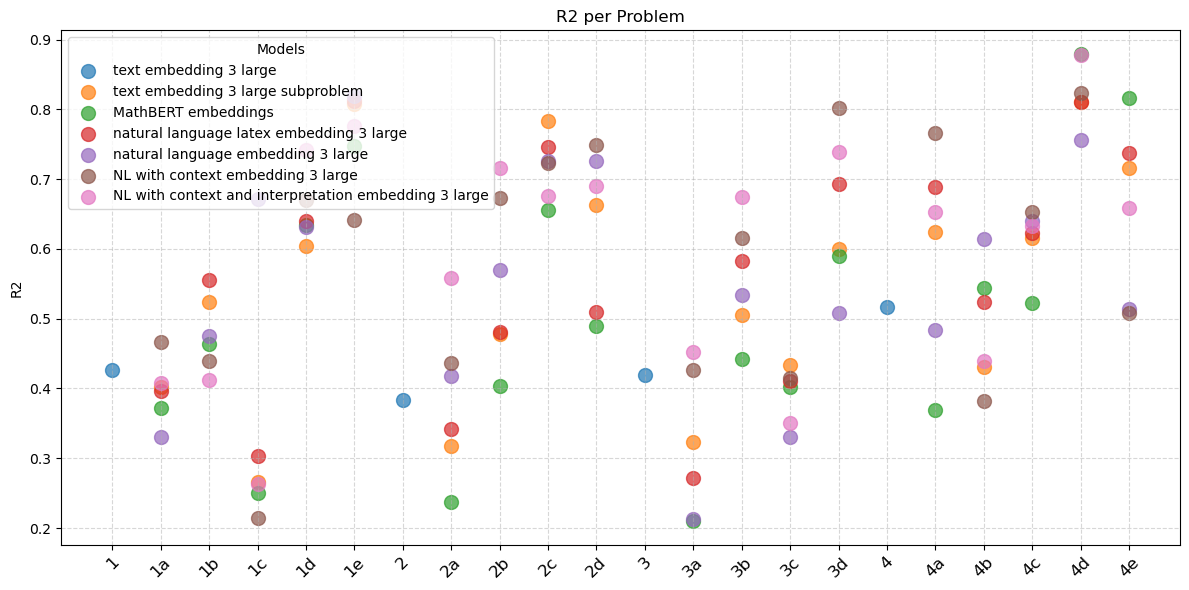

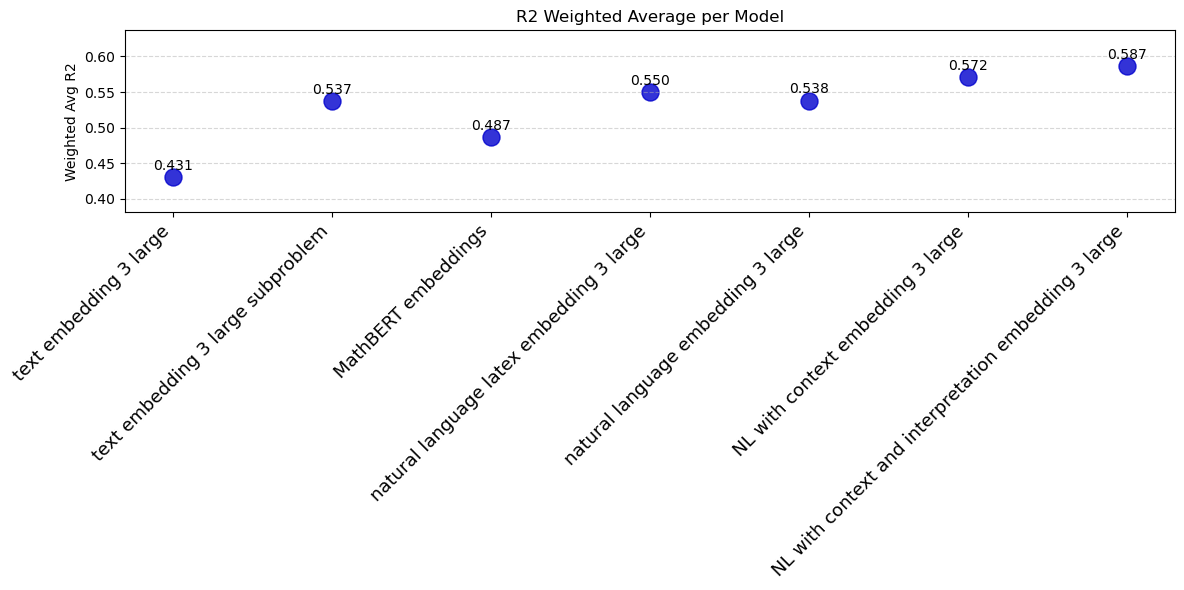

Adding dataset: text embedding 3 large
Adding dataset: text embedding 3 large subproblem
Adding dataset: MathBERT embeddings
Adding dataset: natural language latex embedding 3 large
Adding dataset: natural language embedding 3 large
Adding dataset: NL with context embedding 3 large
Adding dataset: NL with context and interpretation embedding 3 large
All datasets loaded successfully.
All datasets prepared and synchronized across cases.
Clustering completed for all datasets.


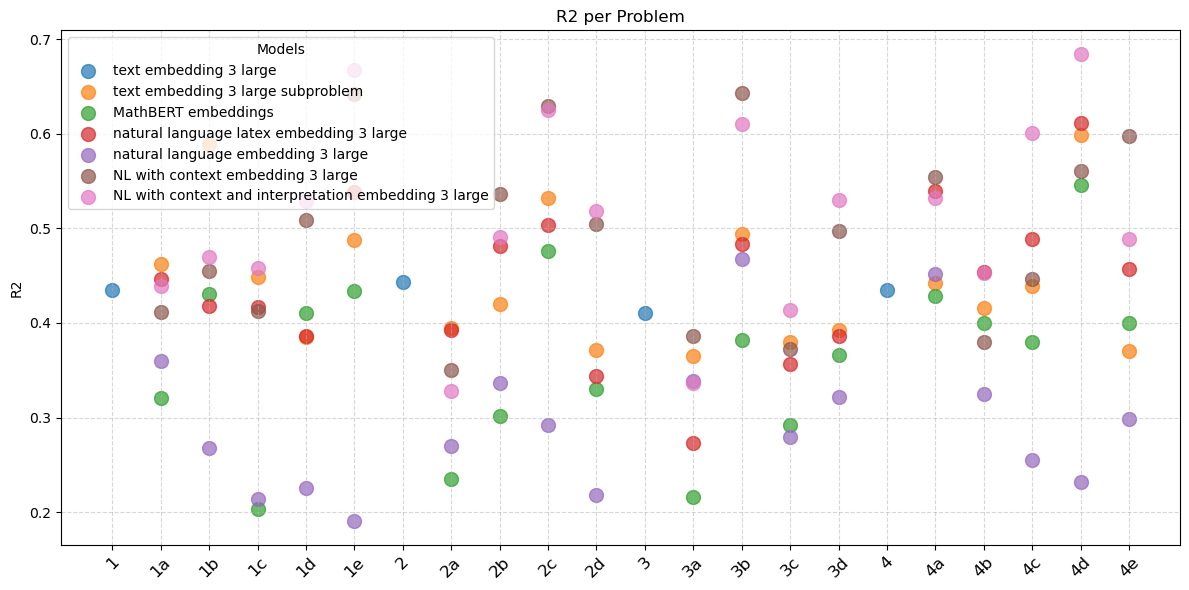

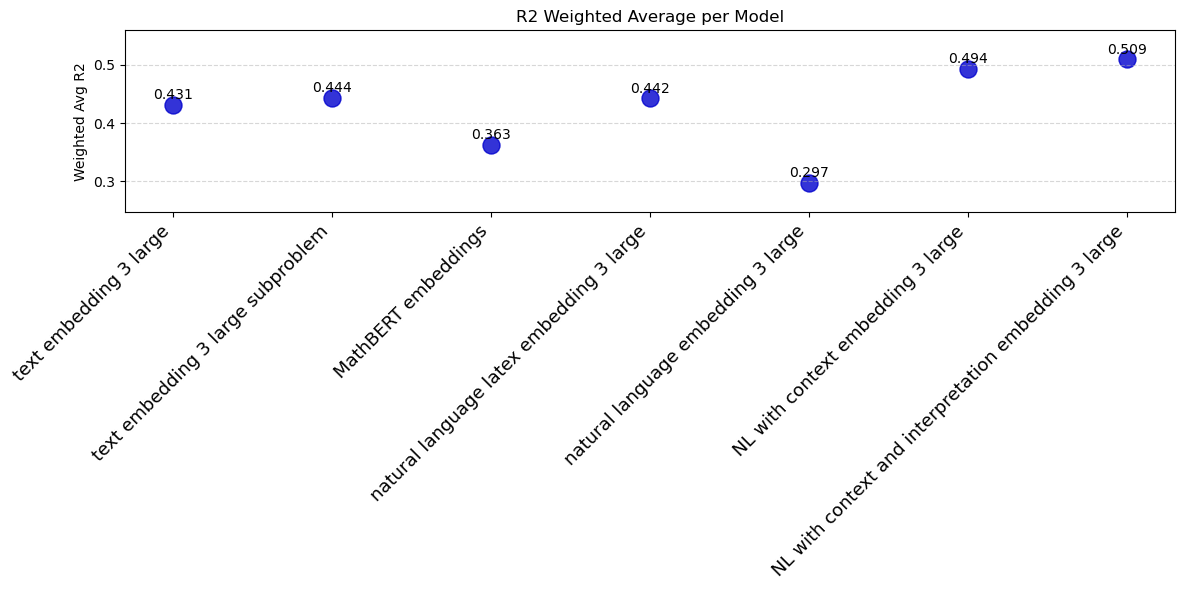

In [17]:
path_emb_6 = "data/split_by_subproblem/NL_with_context_embedding_3_large"
path_emb_4 = "data/split_by_subproblem/natural_language_latex_embedding_3_large"
path_emb_2 = "data/split_by_subproblem/text_embedding_3_large_subproblem"
path_emb_7 = "data/split_by_subproblem/NL_with_context_and_interpretation_embedding_3_large"
path_emb_3 = "data/split_by_subproblem/MathBERT_embeddings"
path_emb_5 = "data/split_by_subproblem/natural_language_embedding_3_large"
path_emb_1 = "data/split_by_problem/text_embedding_3_large"

path_labels_6 = "data/split_by_subproblem/NL_with_context"
path_labels_4 = "data/split_by_subproblem/natural_language_latex"
path_labels_2 = "data/split_by_subproblem/latex"
path_labels_7 = "data/split_by_subproblem/NL_with_context_and_interpretation"
path_labels_3 = "data/split_by_subproblem/latex"
path_labels_5 = "data/split_by_subproblem/natural_language"
path_labels_1 = "data/split_by_problem/latex"



models = MultiModelComparison([
    (path_emb_1, path_labels_1),
    (path_emb_2, path_labels_2),
    (path_emb_3, path_labels_3),
    (path_emb_4, path_labels_4),
    (path_emb_5, path_labels_5),
    (path_emb_6, path_labels_6),
    (path_emb_7, path_labels_7)

])
models.load_data()
models.prepare_data(REMOVE_BAD=True, REMOVE_EMPTY=False)
models.clustering(
    number_of_clusters=20,
    dimensions=12,
    type_of_clustering='Agglomerative',
    type_of_dimension_reduction='PCA',
    type_of_scaler='MinMaxScaler',
    metric='cosine',
    linkage_type='complete'
)

data = models.get_data()
for model_name, task_dict in data:
    print(f"\nModel: {model_name}")
    for problem_key, df in task_dict.items():
        print(f"  {problem_key}: {len(df)} students")

models.analyze(
    features_to_analyze=["r2"],
    comparing_values="avg",
    detail=False,
    plot=True
)

models = MultiModelComparison([
    (path_emb_1, path_labels_1),
    (path_emb_2, path_labels_2),
    (path_emb_3, path_labels_3),
    (path_emb_4, path_labels_4),
    (path_emb_5, path_labels_5),
    (path_emb_6, path_labels_6),
    (path_emb_7, path_labels_7)

])
models.load_data()
models.prepare_data(REMOVE_BAD=False, REMOVE_EMPTY=False)
models.clustering(
    number_of_clusters=50,
    dimensions=12,
    type_of_clustering='Agglomerative',
    type_of_dimension_reduction='PCA',
    type_of_scaler='MinMaxScaler',
    metric='cosine',
    linkage_type='complete'
)
models.analyze(
    features_to_analyze=["r2"],
    comparing_values="min",
    detail=False,
    plot=True
)